In [1]:
#Initial functions, loading data and importing libararies
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from scipy.stats import gaussian_kde

# Read data
df = pd.read_csv('Train_data.csv')

# Beautifying the outputs
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase the display width
pd.set_option('display.float_format', '{:.2f}'.format)  # Display floats with 2 decimal places

# Get numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [2]:
# Small helper function to make tables for the outputs
def maketable(data):
    table = PrettyTable()
    for col, val in data.items():
        table.add_row([col, val])
    return table

In [3]:
# Main plots functions, pmf cdf pdf just copys of each other 
def plot_pmf(df, column):
    pmf = df[column].value_counts(normalize=True)
    plt.figure(figsize=(15, 4))
    pmf.plot(kind='bar')
    plt.title(f'PMF of {column}')
    plt.xlabel(column)
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_pdf(df, column):
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df[column], bw_adjust=0.5, warn_singular=False)
    plt.title(f'PDF of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

def plot_cdf(df, column):
    data = df[column].dropna().sort_values()
    cdf = np.arange(1, len(data) + 1) / len(data)
    plt.figure(figsize=(8, 4))
    plt.plot(data, cdf, linestyle='-', marker='')
    plt.title(f'Cumulative Distribution Function (CDF) of {column}')
    plt.xlabel(column)
    plt.ylabel('Cumulative Probability')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
# The scatter plot function + the joint distribution function plotting
def plotscatter(numericalcols):
    number1 = random.randint(1, len(numericalcols) - 1)
    number2 = random.randint(1, len(numericalcols) - 1)
    x_field = numericalcols[number1]
    y_field = numericalcols[number2]
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_field], df[y_field], alpha=0.5, color='blue')
    plt.title(f'Scatter Plot between {x_field} and {y_field}')
    plt.xlabel(x_field)
    plt.ylabel(y_field)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def analyze_and_plot_joint_distribution(df, numericalcols, categoricalcols):
    def plot_joint_pmf(x_field, y_field):
        joint_counts = pd.crosstab(df[x_field], df[y_field])
        joint_pmf = joint_counts / joint_counts.sum().sum()
        plt.figure(figsize=(30, 16))
        sns.heatmap(joint_pmf, annot=True, cmap='Blues')
        plt.title(f'Joint PMF of {x_field} and {y_field}')
        plt.xlabel(y_field)
        plt.ylabel(x_field)
        plt.show()

    def plot_joint_pdf(x_field, y_field):
        filtered_df = df[[x_field, y_field]].drop_duplicates().dropna()
        if filtered_df[x_field].nunique() < 2 or filtered_df[y_field].nunique() < 2:
            print(f"Skipping {x_field} and {y_field} due to insufficient unique values.")
            return
        plt.figure(figsize=(10, 6))
        sns.kdeplot(x=filtered_df[x_field], y=filtered_df[y_field], fill=True, cmap='Blues', thresh=0, bw_adjust=0.5)
        plt.title(f'Joint PDF of {x_field} and {y_field}')
        plt.xlabel(x_field)
        plt.ylabel(y_field)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if len(numericalcols) > 1:
        number1, number2 = random.sample(range(len(numericalcols)), 2)
        x_field = numericalcols[number1]
        y_field = numericalcols[number2]
        plot_joint_pdf(x_field, y_field)
    
    if len(categoricalcols) > 1:
        number1, number2 = random.sample(range(len(categoricalcols)), 2)
        x_field = categoricalcols[number1]
        y_field = categoricalcols[number2]
        plot_joint_pmf(x_field, y_field)

In [5]:
# Checking the data and plotting accordingly pdf / pmf+cdf
def analyze_and_plot_distributions(df, class_column):
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':
            # Categorical data: calculate and plot PMF
            plot_pmf(df, column)
        elif np.issubdtype(df[column].dtype, np.number):
            # Continuous data: calculate and plot PDF and CDF
            # Drop NaN values for KDE
            plot_pdf(df.dropna(subset=[column]), column)  # Plot PDF

            # Now add logic to calculate and plot conditional PDFs
            normal_data = df[df[class_column] == 'normal'][column].dropna()
            anomaly_data = df[df[class_column] == 'anomaly'][column].dropna()

            # Create a new plot for conditional PDFs
            plt.figure(figsize=(10, 6))

            # Plot PDF for the entire dataset
            sns.kdeplot(df[column].dropna(), color='blue', label='PDF of All Data', linewidth=2, warn_singular=False)

            # Plot PDF for normal class
            sns.kdeplot(normal_data, color='green', label='PDF of Normal Class', linewidth=2, warn_singular=False)

            # Plot PDF for anomaly class
            sns.kdeplot(anomaly_data, color='red', label='PDF of Anomaly Class', linewidth=2, warn_singular=False)

            # Set titles and labels
            plt.title(f'Conditional PDF of {column} Given Class')
            plt.xlabel(column)
            plt.ylabel('Density')
            plt.legend()  # This will now have the correct entries
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Plot the CDF
            plot_cdf(df, column)  # Plot the CDF for the whole dataset
        else:
            print(f"\nSkipping column {column} with type {df[column].dtype}")
##################
def analyze_and_plot_conditional_joint_distribution(df, class_column, numericalcols, categoricalcols):
    """
    Analyzes and plots conditional joint distributions for pairs of fields given a class.
    Randomly selects pairs of fields to plot.
    """

    # Function to calculate and plot conditional joint PMF for categorical fields
    def plot_conditional_joint_pmf(x_field, y_field, class_value):
        data_subset = df[df[class_column] == class_value]
        joint_counts = pd.crosstab(data_subset[x_field], data_subset[y_field])
        joint_pmf = joint_counts / joint_counts.sum().sum()  # Normalize to get PMF

        plt.figure(figsize=(20, 12))
        sns.heatmap(joint_pmf, annot=True, cmap='Blues')
        plt.title(f'Joint PMF of {x_field} and {y_field} for {class_column} = {class_value}')
        plt.xlabel(y_field)
        plt.ylabel(x_field)
        plt.show()

    # Function to calculate and plot conditional joint PDF for numerical fields
    def plot_conditional_joint_pdf(x_field, y_field, class_value):
        data_subset = df[df[class_column] == class_value]
        filtered_data = data_subset[[x_field, y_field]].dropna().drop_duplicates()

        # Ensure sufficient unique values before plotting
        if filtered_data[x_field].nunique() < 2 or filtered_data[y_field].nunique() < 2:
            print(f"Skipping {x_field} and {y_field} for {class_value} due to insufficient unique values.")
            return

        plt.figure(figsize=(10, 6))
        try:
            # Use KDE for plotting with increased smoothing
            sns.kdeplot(
                x=filtered_data[x_field],
                y=filtered_data[y_field],
                fill=True,
                cmap='viridis',
                bw_adjust=1.0  # Adjust this value as needed
            )
            plt.title(f'Conditional Joint PDF of {x_field} and {y_field} for {class_column} = {class_value}')
            plt.xlabel(x_field)
            plt.ylabel(y_field)
            plt.grid(True)
            plt.show()

        except ValueError as e:
            print(f"Skipping plot for {x_field} vs {y_field} due to error: {e}")

    # Get unique class values
    class_values = df[class_column].unique()

    # Randomly select pairs of numerical fields and plot conditional joint PDFs
    if len(numericalcols) >= 2:
        number1 = random.randint(0, len(numericalcols) - 1)
        number2 = random.randint(0, len(numericalcols) - 1)
        while number1 == number2:  # Ensure the fields are different
            number2 = random.randint(0, len(numericalcols) - 1)

        x_field = numericalcols[number1]
        y_field = numericalcols[number2]

        for class_value in class_values:
            plot_conditional_joint_pdf(x_field, y_field, class_value)

    # Randomly select pairs of categorical fields and plot conditional joint PMFs
    if len(categoricalcols) >= 2:
        category1 = random.randint(0, len(categoricalcols) - 1)
        category2 = random.randint(0, len(categoricalcols) - 1)
        while category1 == category2:  # Ensure the fields are different
            category2 = random.randint(0, len(categoricalcols) - 1)

        x_field = categoricalcols[category1]
        y_field = categoricalcols[category2]

        for class_value in class_values:
            plot_conditional_joint_pmf(x_field, y_field, class_value)

In [6]:
# General overview of the data
# Listing columns and data types
columns = df.columns
print(columns, "\n")
data_heads = df.dtypes
print(data_heads, "\n")

# Check for missing values
missing_data = df.isnull().sum()
table = maketable(missing_data)
table.field_names = ["Column", "Missing values"]
print("Number of missing values per column:\n", table, "\n")

# Replace infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'], dtype='object') 

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
lan

In [7]:
# Select only numeric columns using `select_dtypes`
numeric_df = df.select_dtypes(include=[np.number])

# Calculate each measure individually
max_values = numeric_df.max()
min_values = numeric_df.min()
mean_values = numeric_df.mean()
variance_values = numeric_df.var()

# Create tables for each statistic
table1 = maketable(max_values)
table2 = maketable(min_values)
table3 = maketable(mean_values)
table4 = maketable(variance_values)

table1.field_names = ["Column", "Max values"]
table2.field_names = ["Column", "Min values"]
table3.field_names = ["Column", "Mean values"]
table4.field_names = ["Column", "Variance values"]

print("Maximum values:\n", table1, "\n")
print("Minimum values:\n", table2, "\n")
print("Mean values:\n", table3, "\n")
print("Variance values:\n", table4, "\n")


Maximum values:
 +-----------------------------+-------------+
|            Column           |  Max values |
+-----------------------------+-------------+
|           duration          |   42862.0   |
|          src_bytes          | 381709090.0 |
|          dst_bytes          |  5151385.0  |
|             land            |     1.0     |
|        wrong_fragment       |     3.0     |
|            urgent           |     1.0     |
|             hot             |     77.0    |
|      num_failed_logins      |     4.0     |
|          logged_in          |     1.0     |
|       num_compromised       |    884.0    |
|          root_shell         |     1.0     |
|         su_attempted        |     2.0     |
|           num_root          |    975.0    |
|      num_file_creations     |     40.0    |
|          num_shells         |     1.0     |
|       num_access_files      |     8.0     |
|      num_outbound_cmds      |     0.0     |
|        is_host_login        |     0.0     |
|        is_guest

                             duration  src_bytes  dst_bytes  land  wrong_fragment  urgent   hot  num_failed_logins  logged_in  num_compromised  root_shell  su_attempted  num_root  num_file_creations  num_shells  num_access_files  num_outbound_cmds  is_host_login  is_guest_login  count  srv_count  serror_rate  srv_serror_rate  rerror_rate  srv_rerror_rate  same_srv_rate  diff_srv_rate  srv_diff_host_rate  dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate
duration                         1.00       0.08       0.01 -0.00           -0.01   -0.00  0.00               0.01      -0.06             0.10        0.05          0.09      0.09                0.09       -0.00              0.07                NaN            NaN           -0.00  -0.08      -0.04        -0.07            -0.07         0.21             0.2

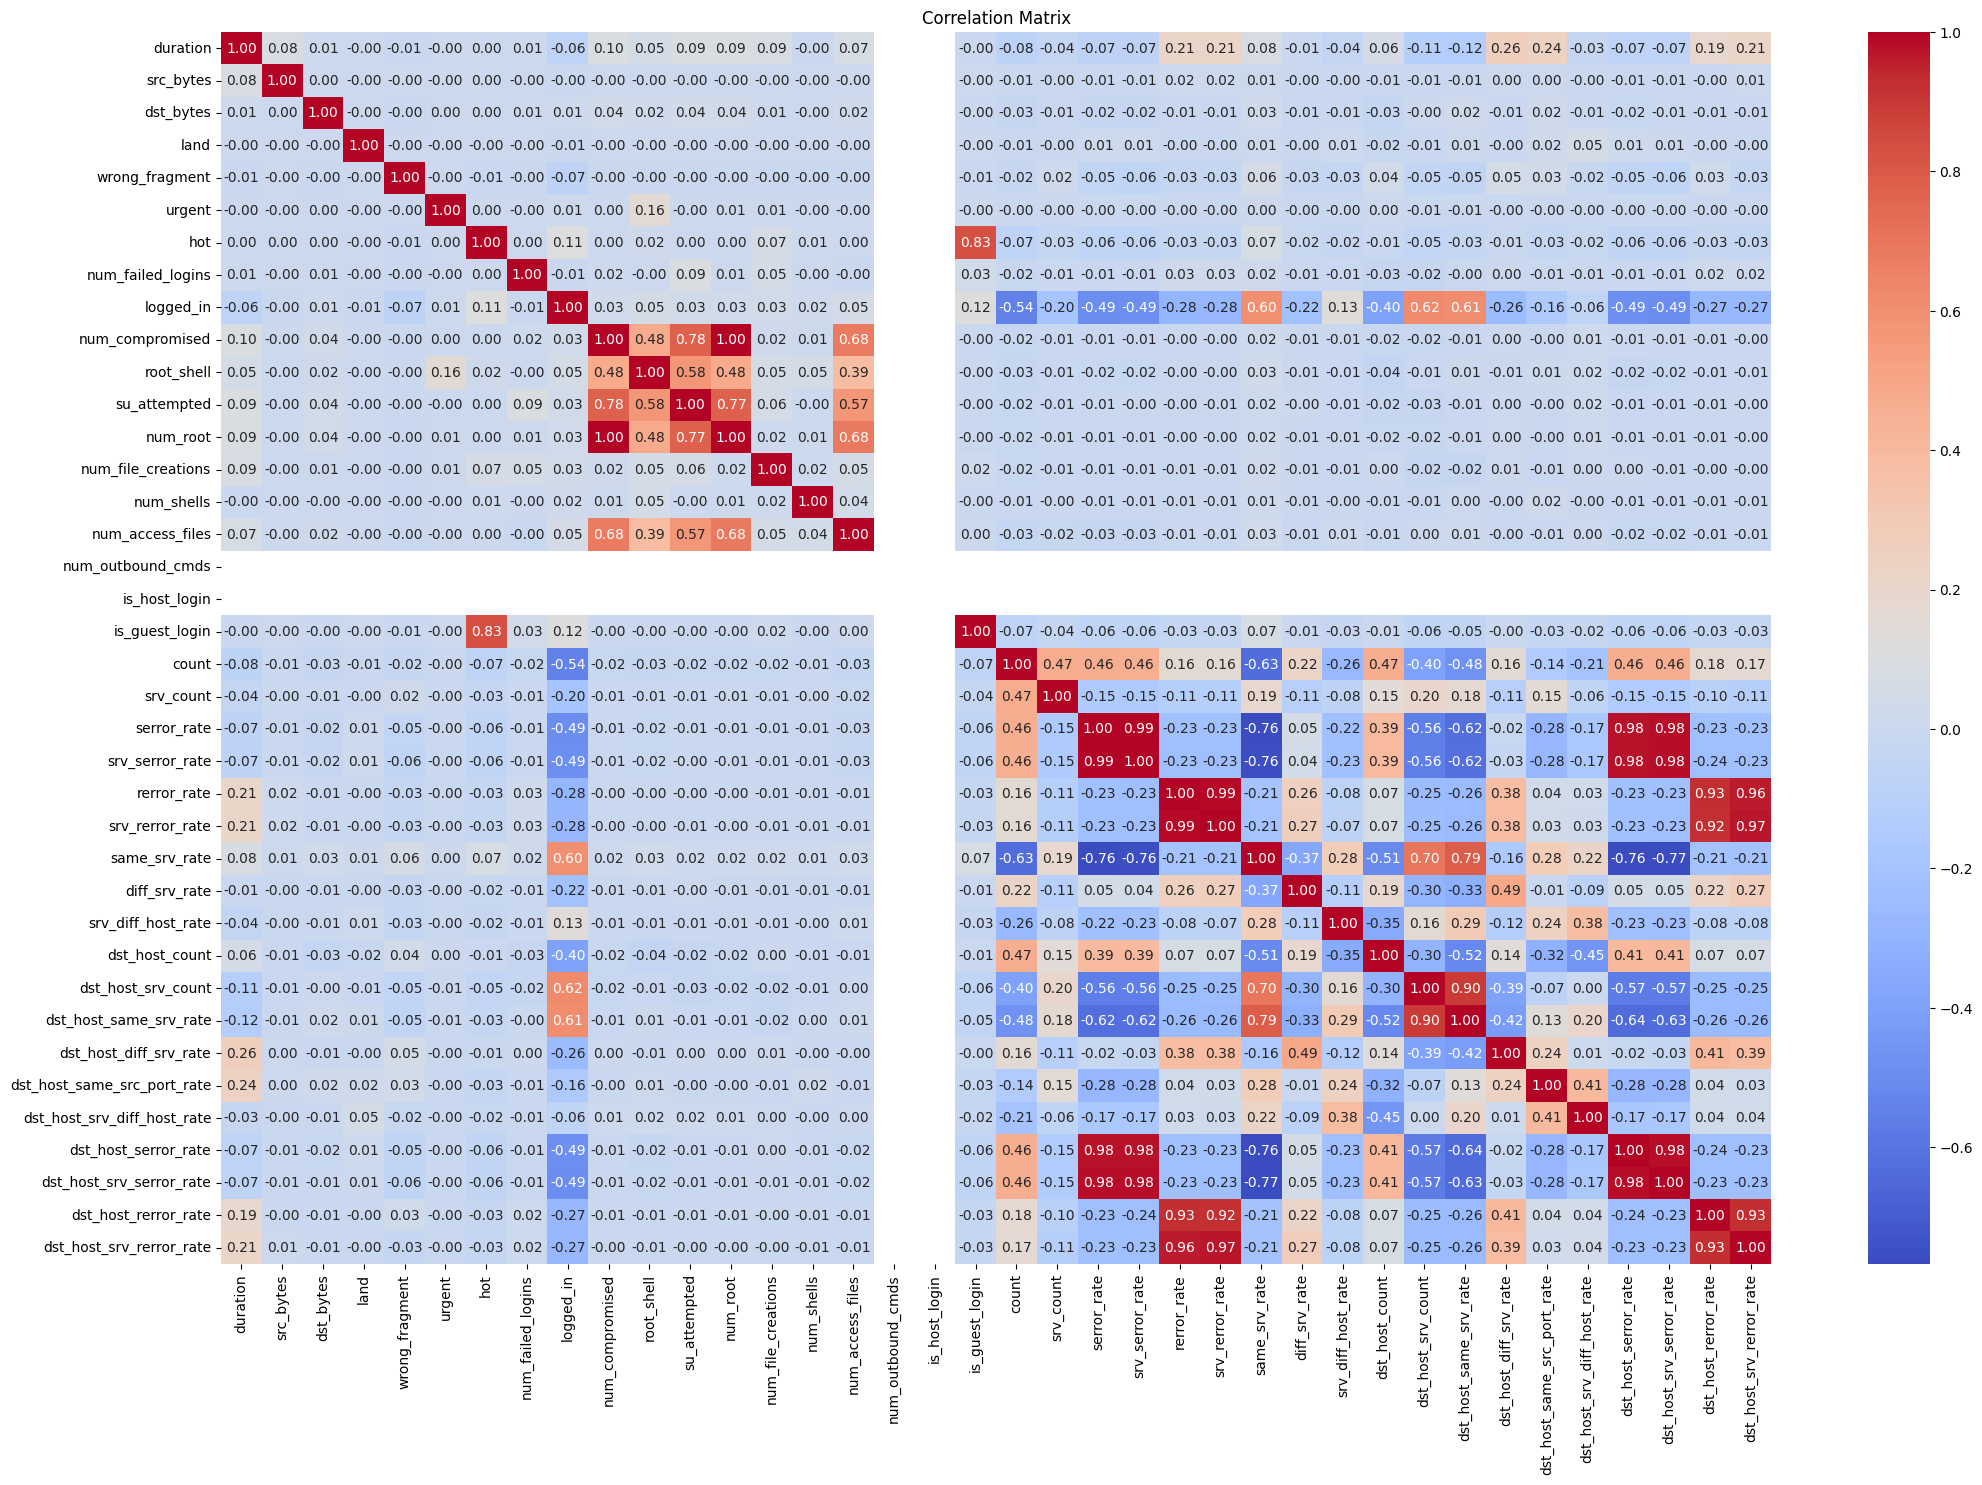

In [8]:
# Calculate the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

correlation_matrix = numeric_df.corr()

# Print the correlation matrix
print(correlation_matrix)
plt.figure(figsize=(25, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [13]:
# Define the class column for the dataset (assumed to be the target variable)
class_col = 'class'

# Select numeric fields from the DataFrame
numeric_fields = df.select_dtypes(include=['float64', 'int64']).columns

# Select categorical fields from the DataFrame
categorical_fields = df.select_dtypes(include=['object']).columns

# Analyzing Numeric Fields
print("Analyzing numeric fields:")
for col in numeric_fields:
    # Skip the class column to avoid incorrect grouping
    if col != class_col:  
        # Group by the class column and calculate the mean value for each class
        correlation_with_attack = df.groupby(class_col)[col].mean()
        
        # Print the field name and its mean values per class (Anomaly/Normal)
        print(f"\nField: {col}")
        print(f"Mean values per class (Anomaly/Normal):\n{correlation_with_attack}")

# Analyzing Categorical Fields
print("\nAnalyzing categorical fields:")
for col in categorical_fields:
    # Skip the class column to avoid incorrect usage
    if col != class_col:  
        # Group by the class column and count the occurrences of each category
        correlation_with_attack = df.groupby(class_col)[col].value_counts()
        
        # Print the field name and its value counts per class (Anomaly/Normal)
        print(f"\nField: {col}")
        print(f"Value counts per class (Anomaly/Normal):\n{correlation_with_attack}")


Analyzing numeric fields:

Field: duration
Mean values per class (Anomaly/Normal):
class
anomaly   451.40
normal    177.27
Name: duration, dtype: float64

Field: src_bytes
Mean values per class (Anomaly/Normal):
class
anomaly   39146.19
normal    11394.41
Name: src_bytes, dtype: float64

Field: dst_bytes
Mean values per class (Anomaly/Normal):
class
anomaly   2450.98
normal    4400.68
Name: dst_bytes, dtype: float64

Field: land
Mean values per class (Anomaly/Normal):
class
anomaly   0.00
normal    0.00
Name: land, dtype: float64

Field: wrong_fragment
Mean values per class (Anomaly/Normal):
class
anomaly   0.05
normal    0.00
Name: wrong_fragment, dtype: float64

Field: urgent
Mean values per class (Anomaly/Normal):
class
anomaly   0.00
normal    0.00
Name: urgent, dtype: float64

Field: hot
Mean values per class (Anomaly/Normal):
class
anomaly   0.17
normal    0.22
Name: hot, dtype: float64

Field: num_failed_logins
Mean values per class (Anomaly/Normal):
class
anomaly   0.00
normal 

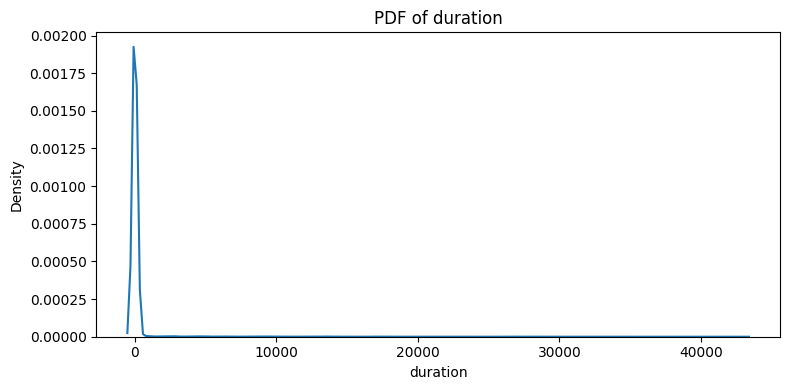

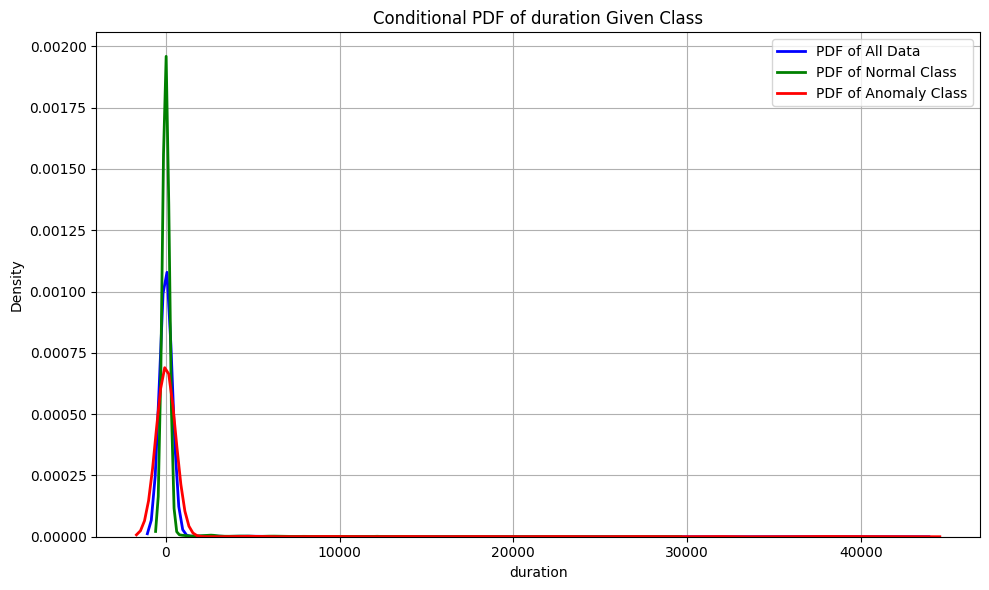

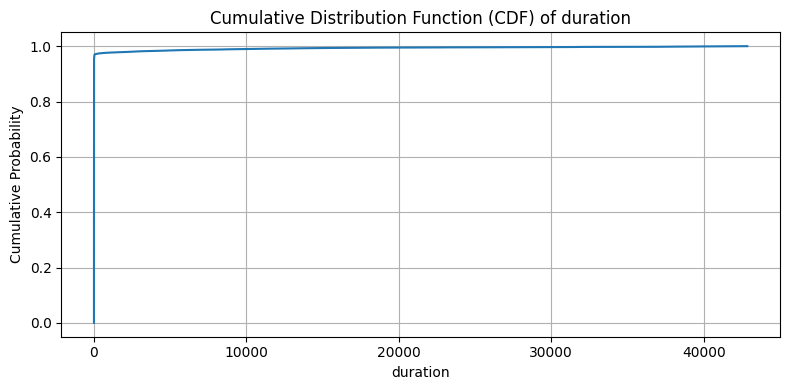

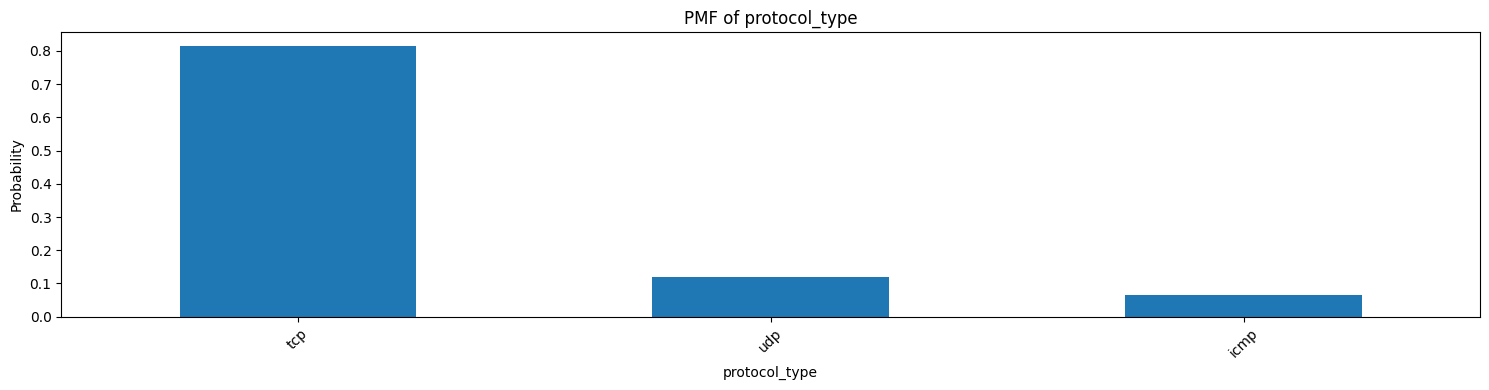

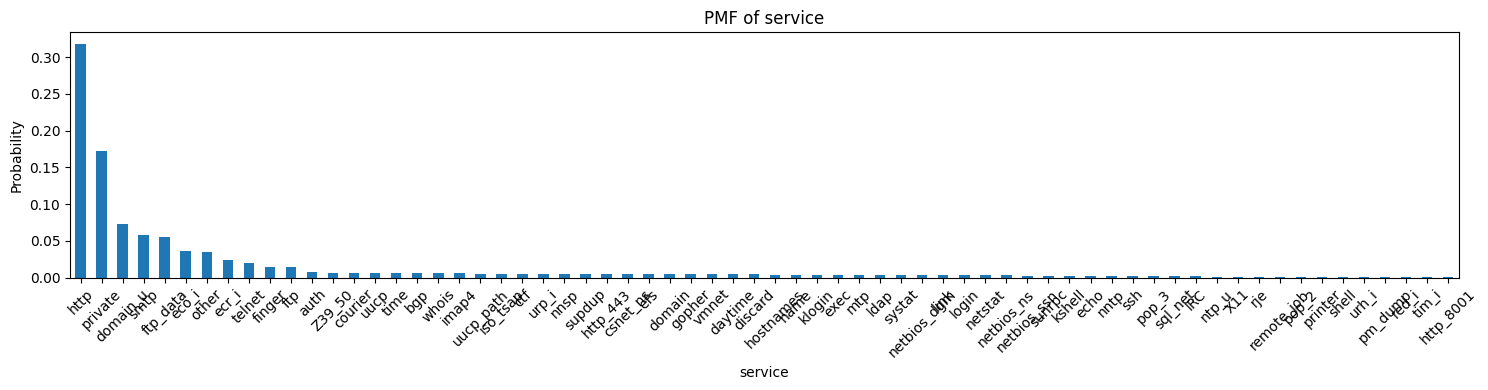

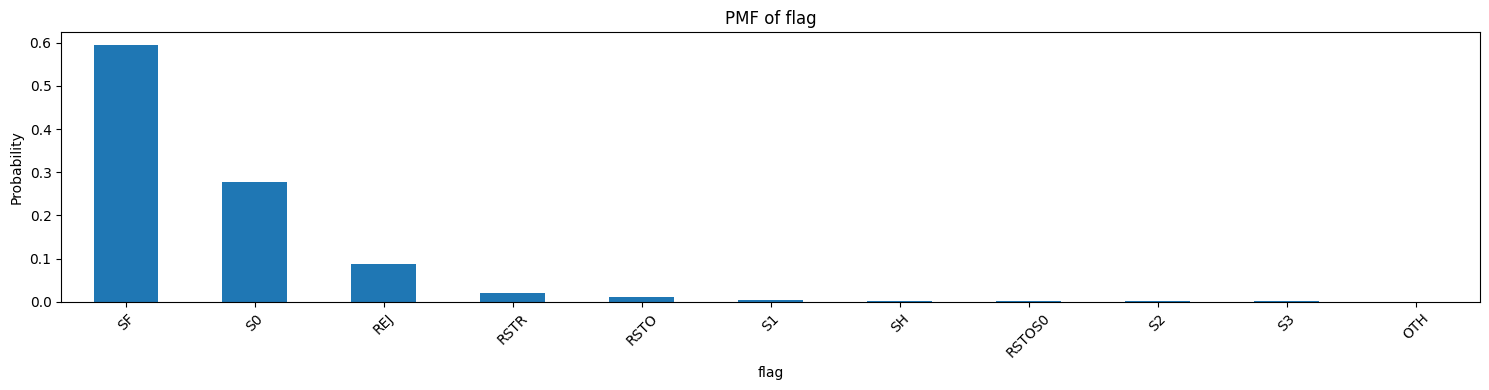

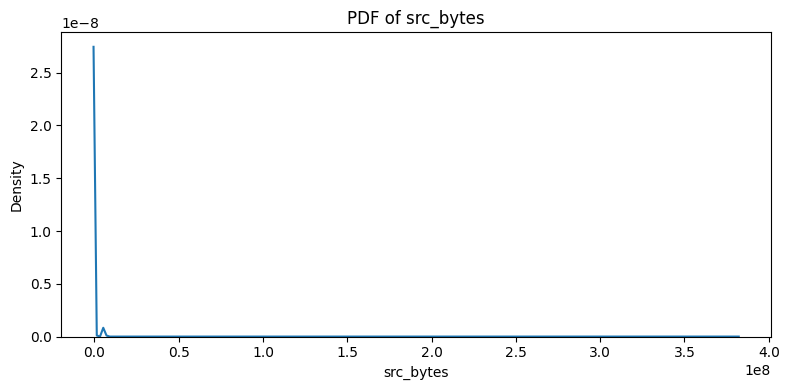

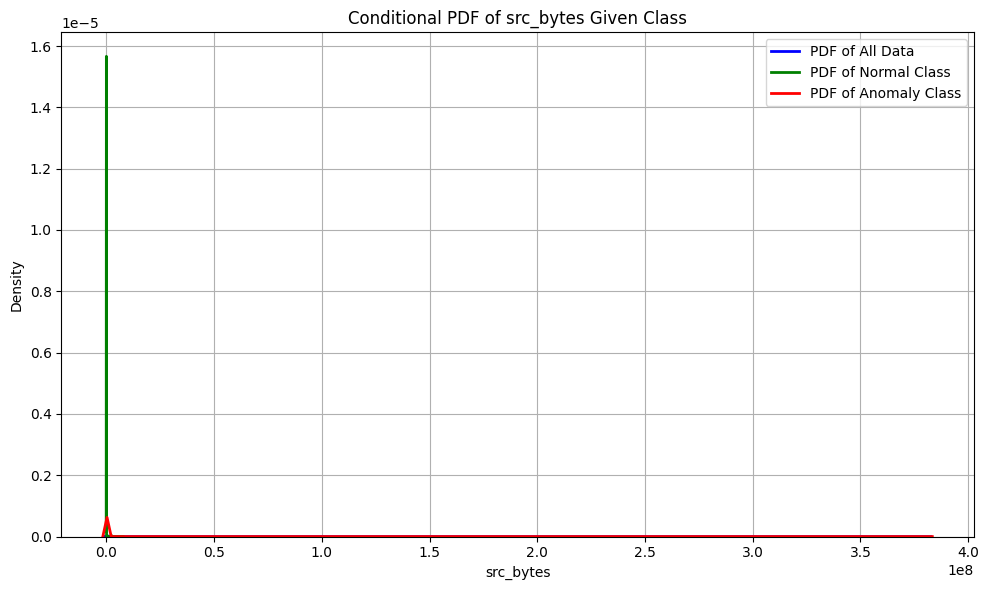

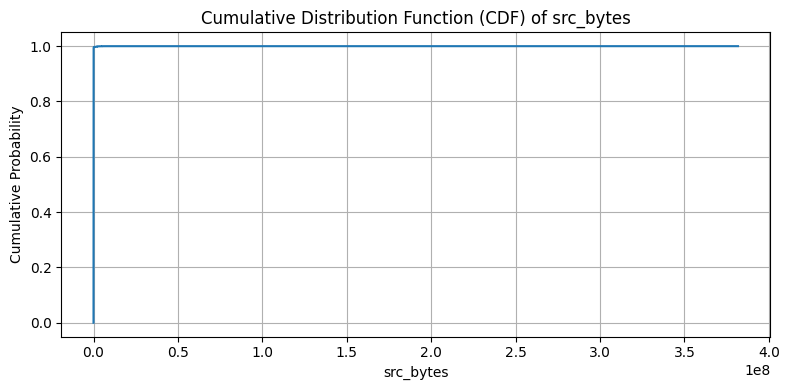

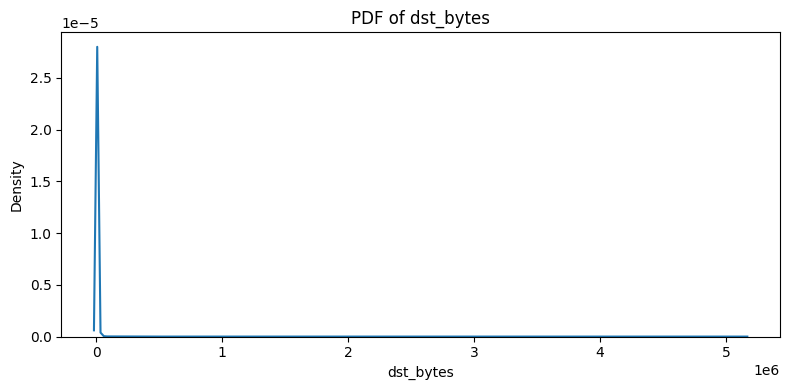

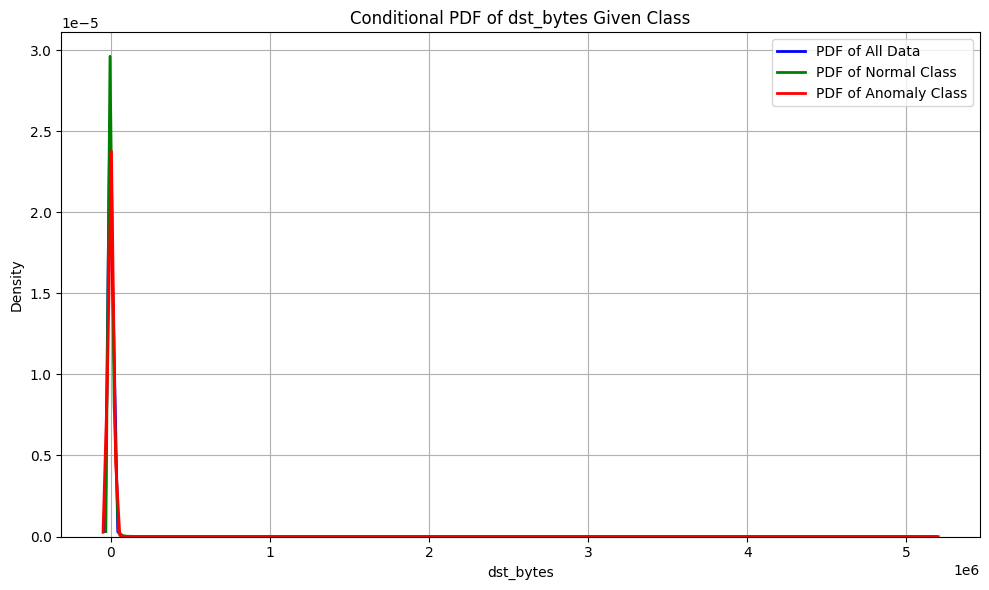

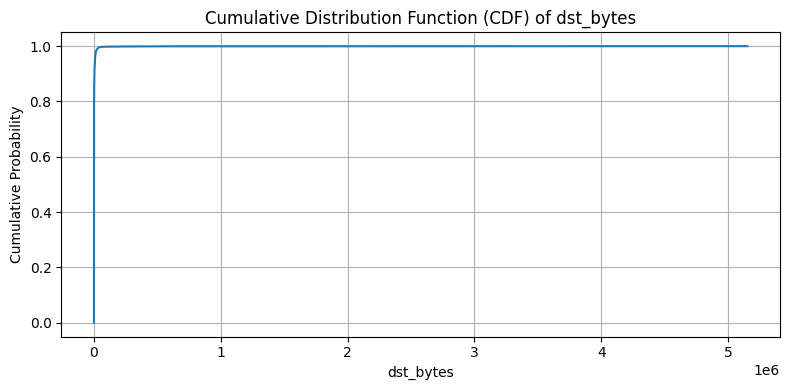

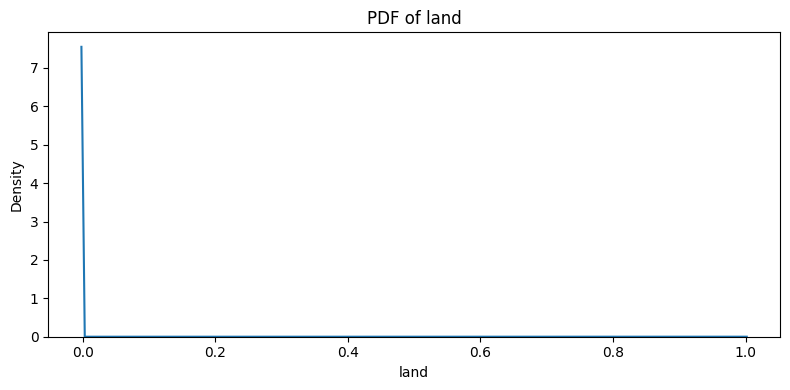

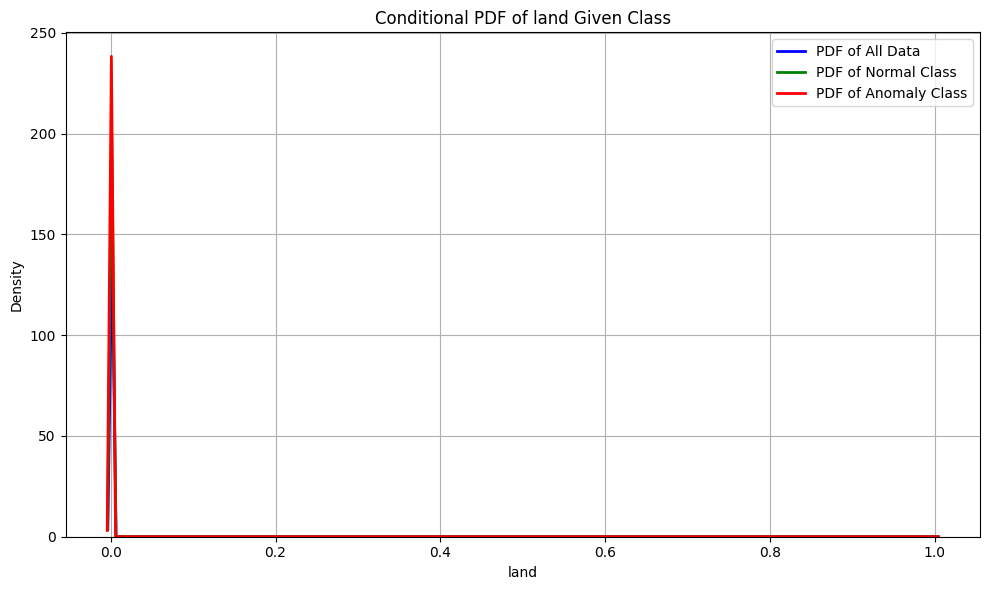

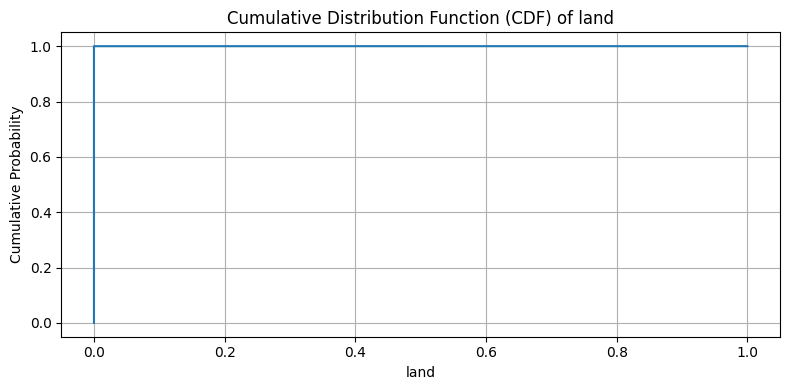

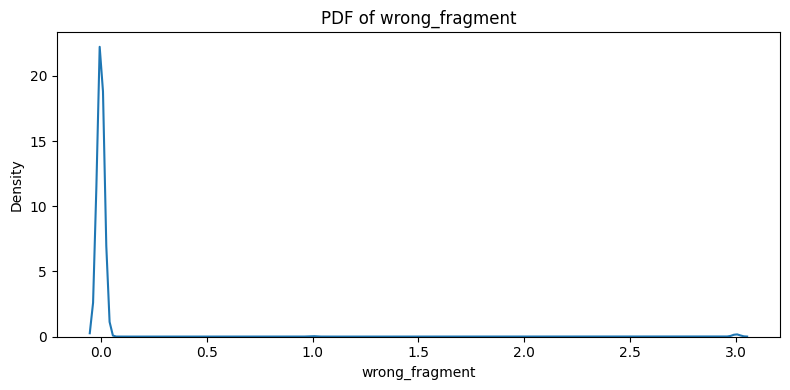

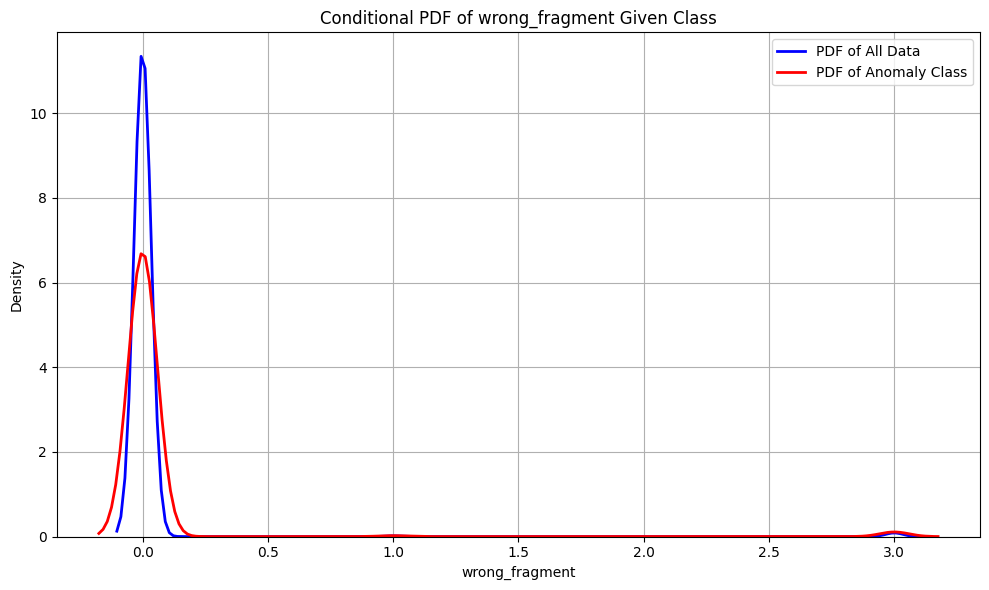

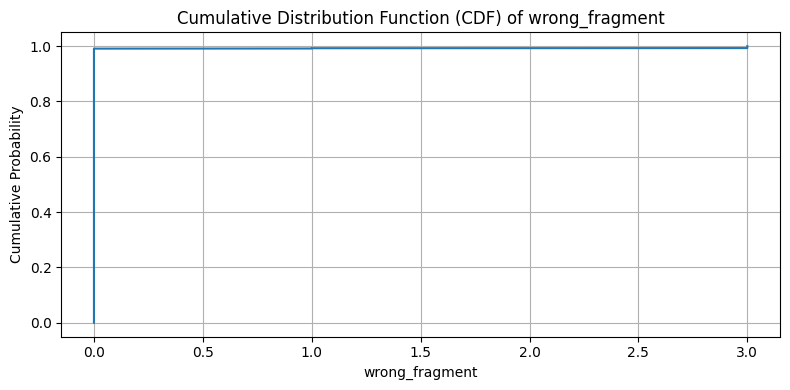

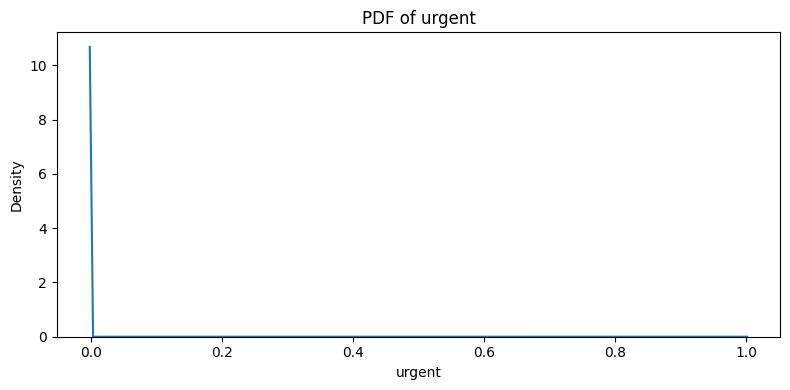

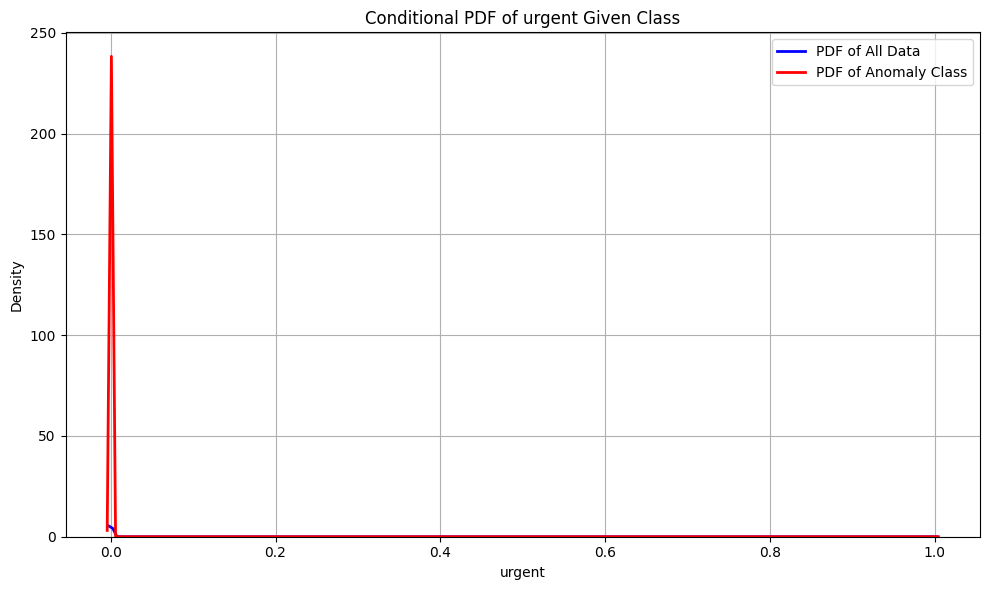

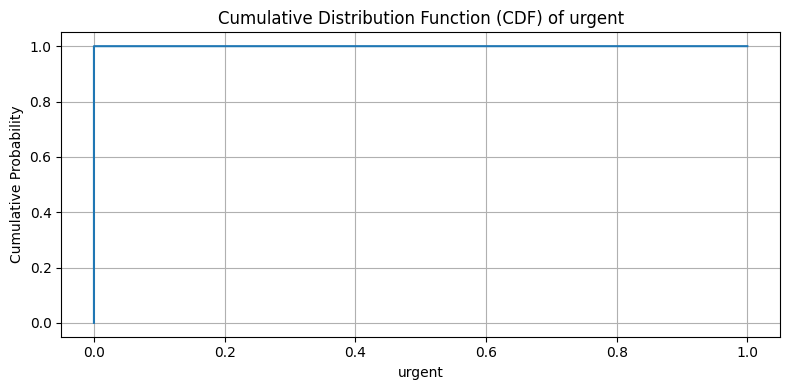

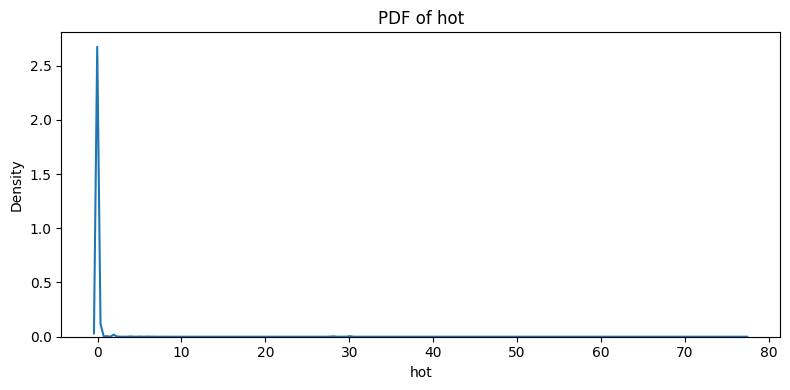

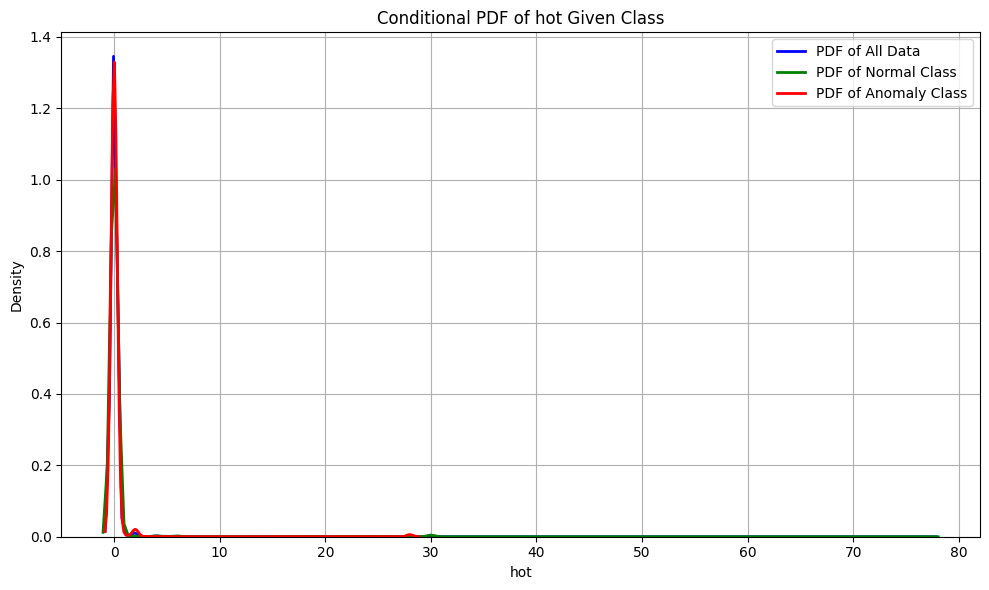

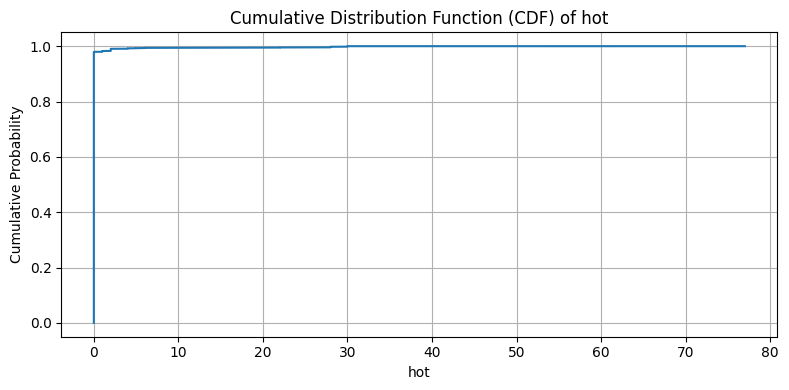

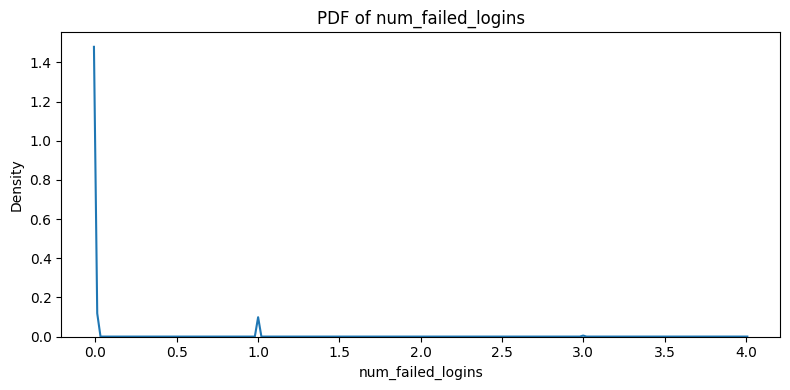

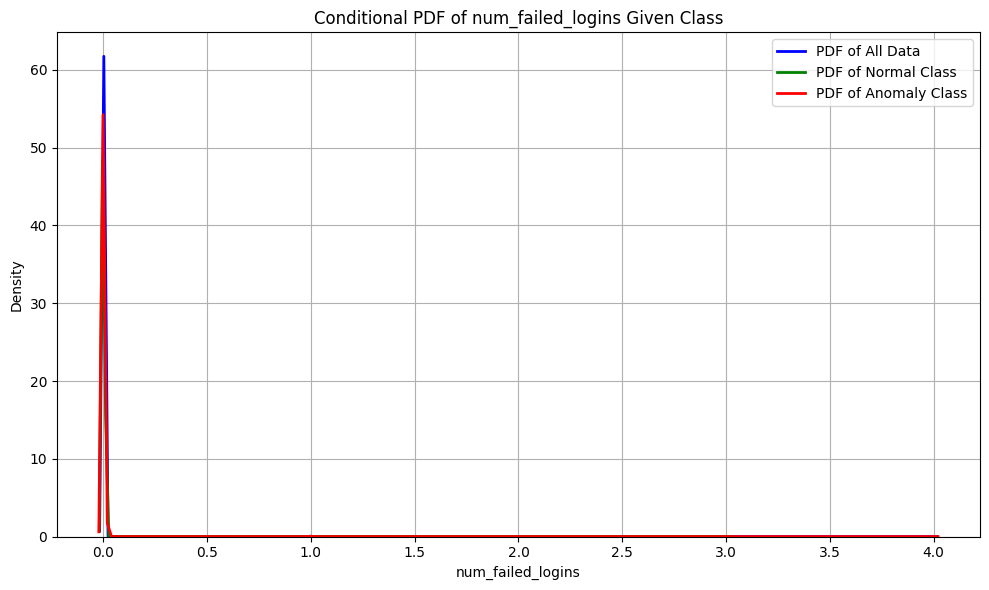

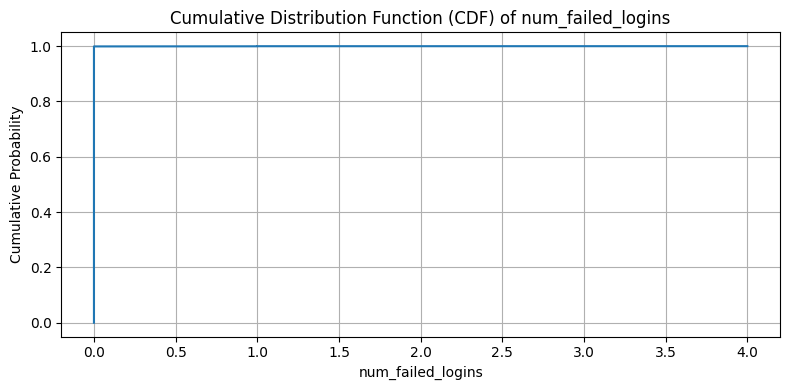

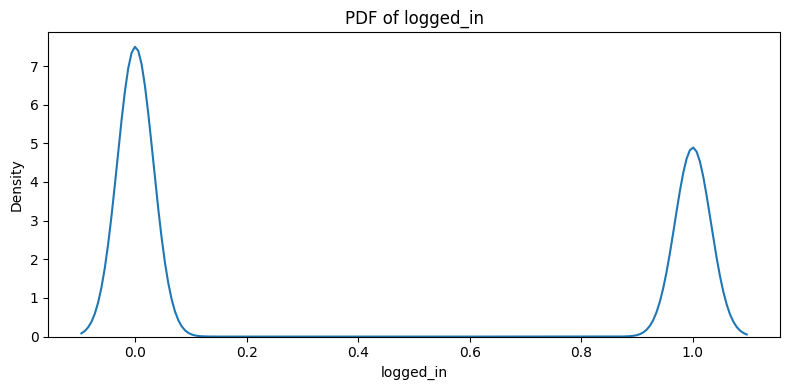

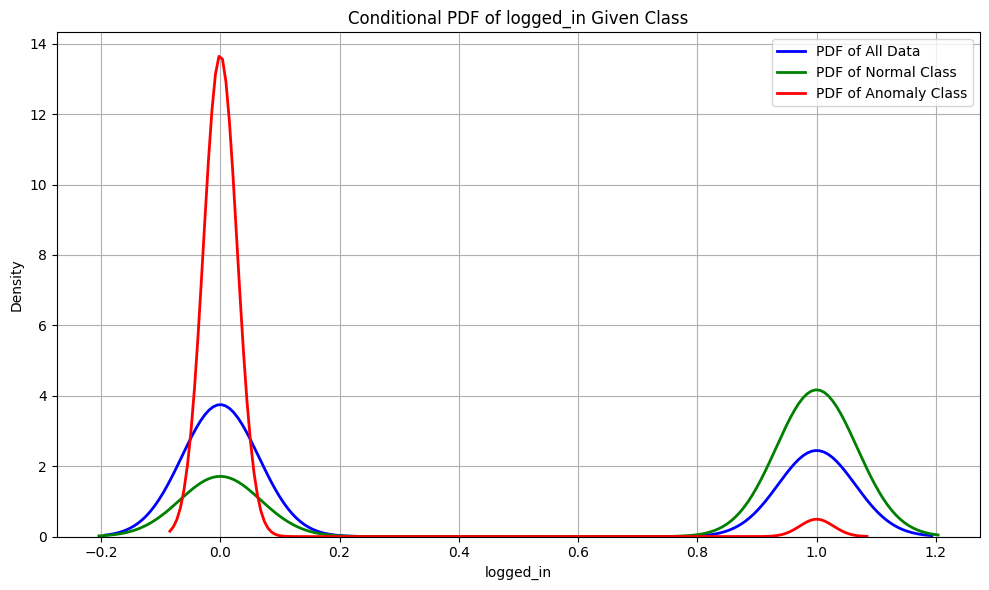

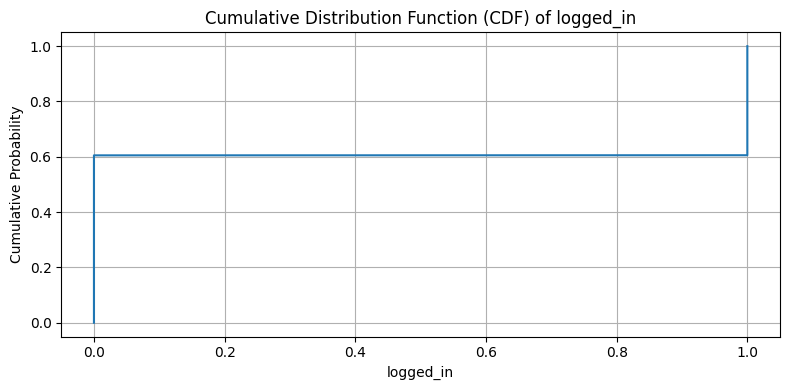

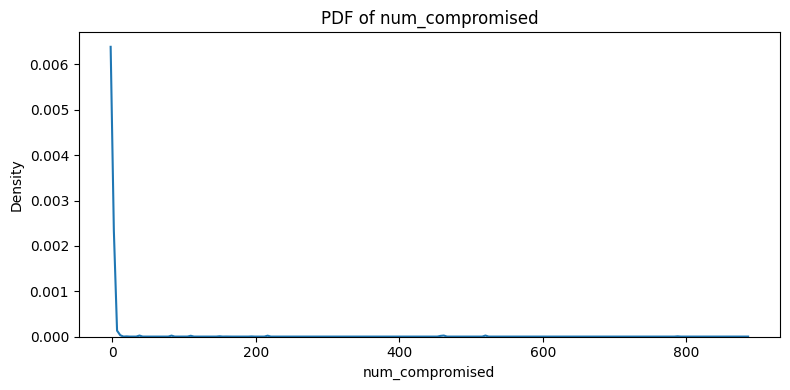

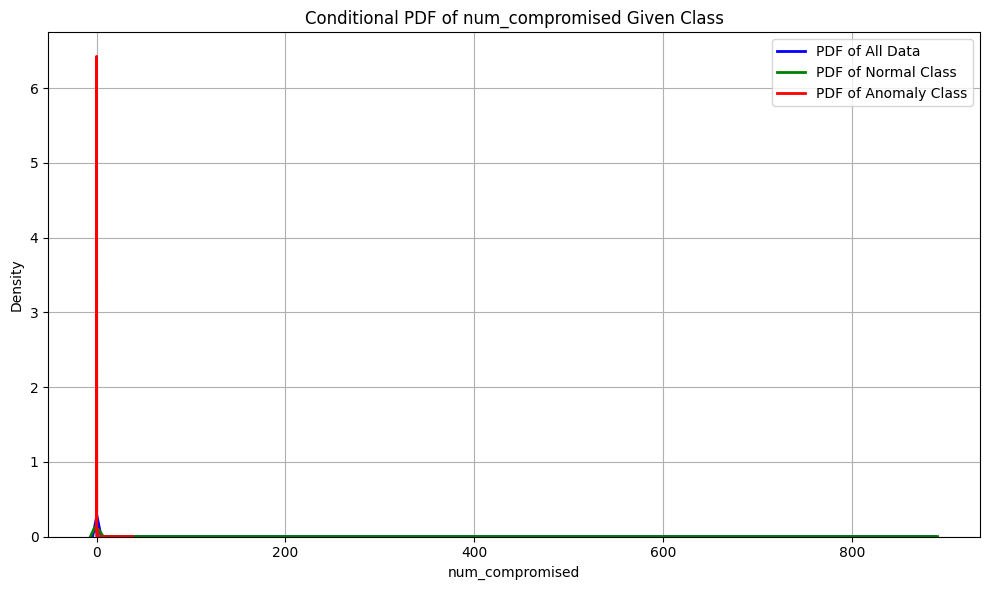

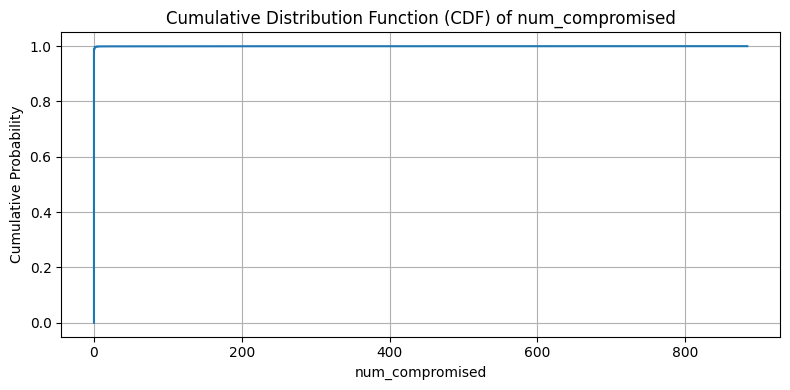

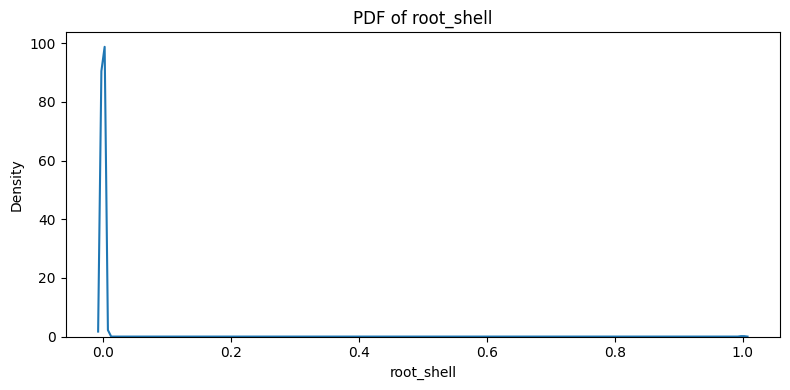

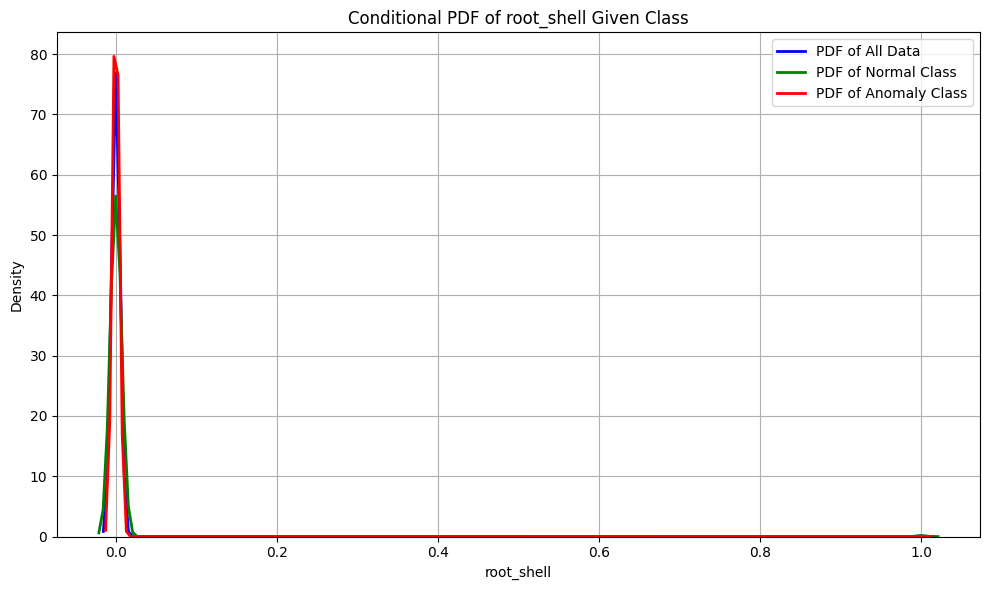

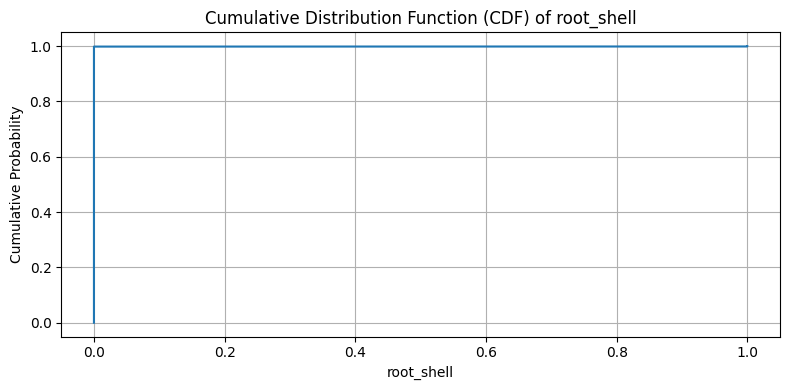

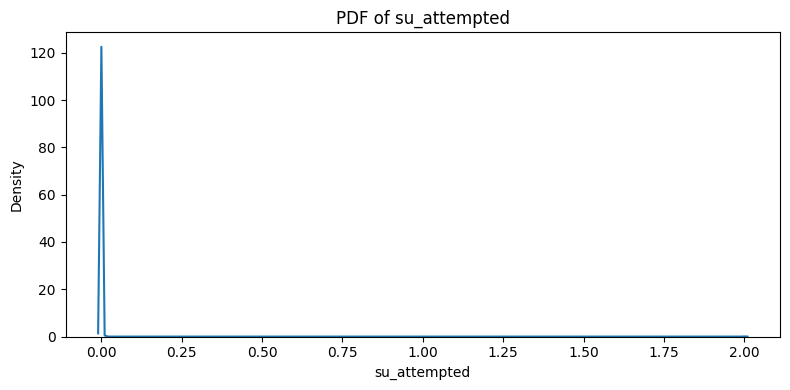

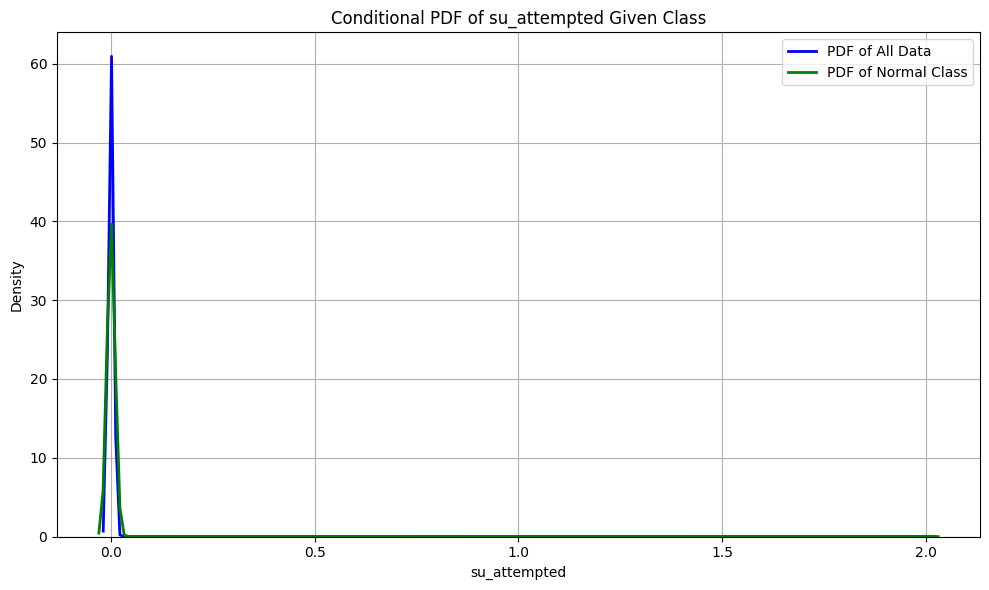

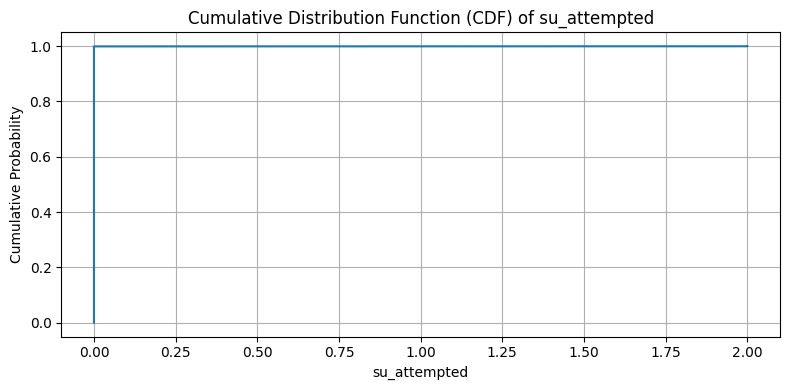

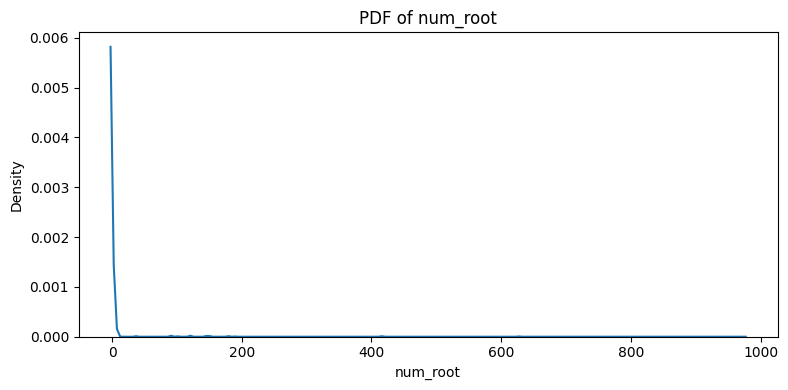

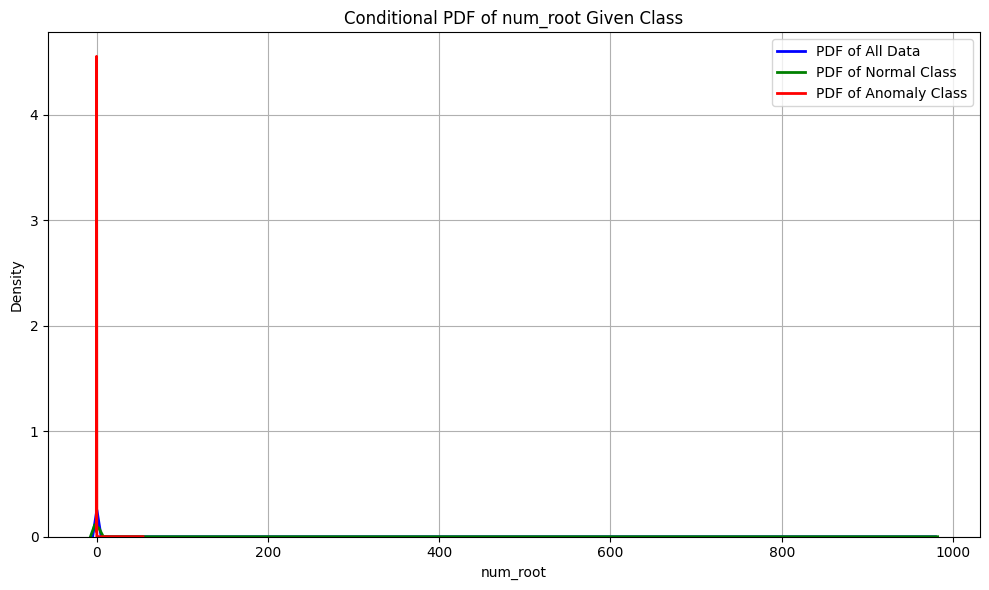

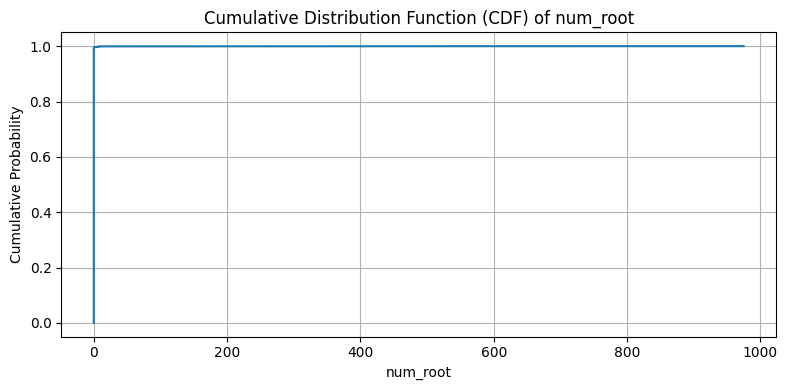

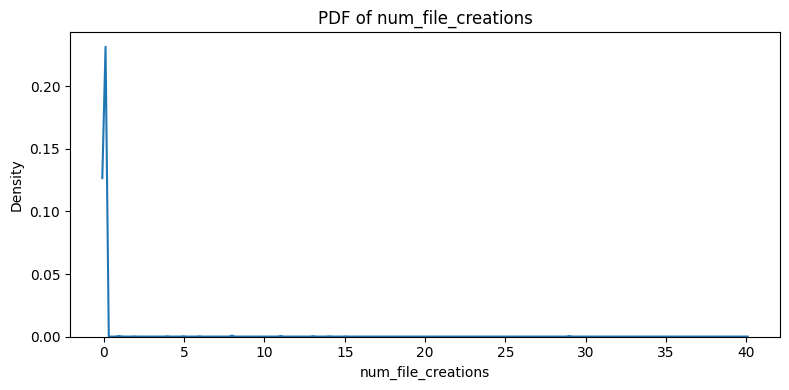

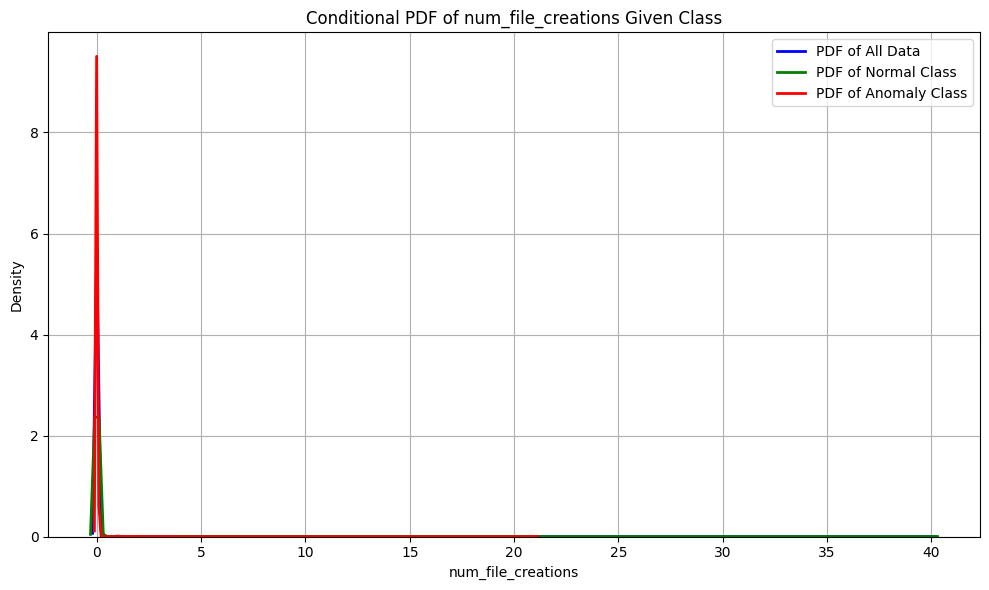

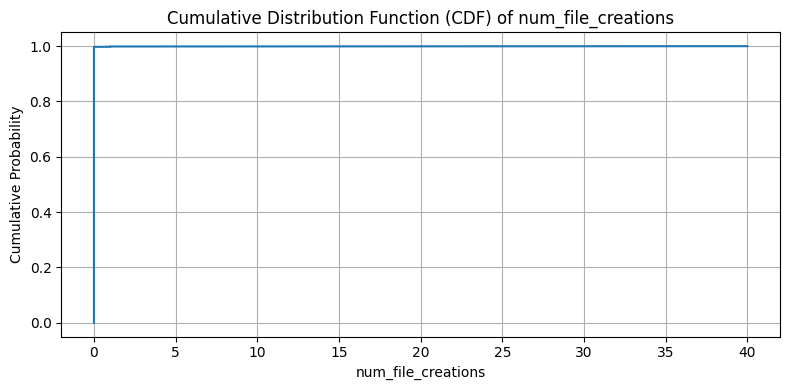

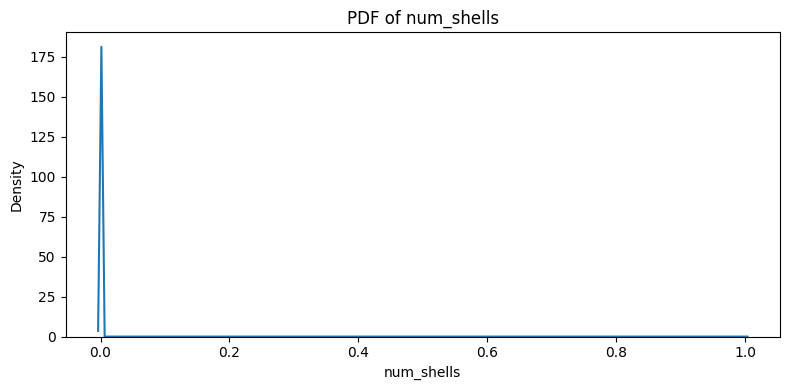

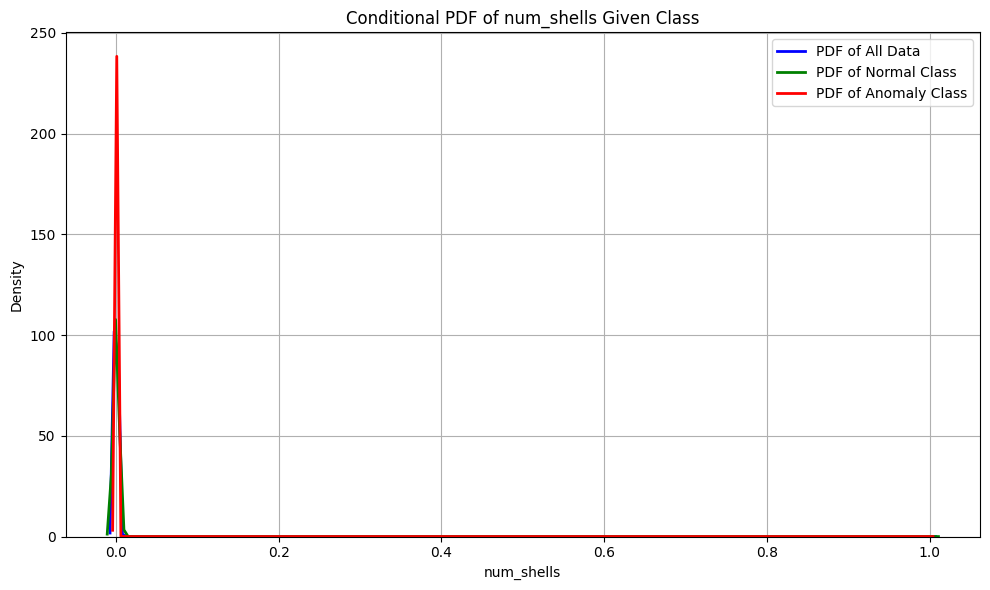

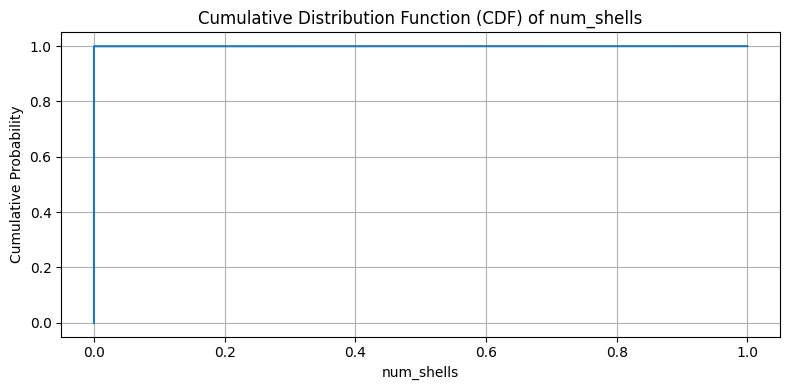

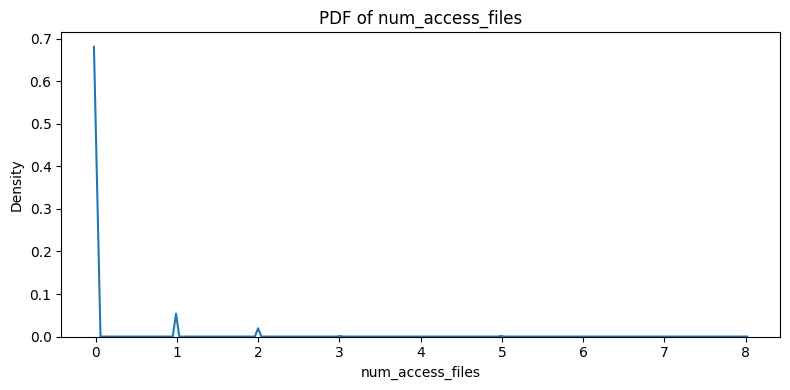

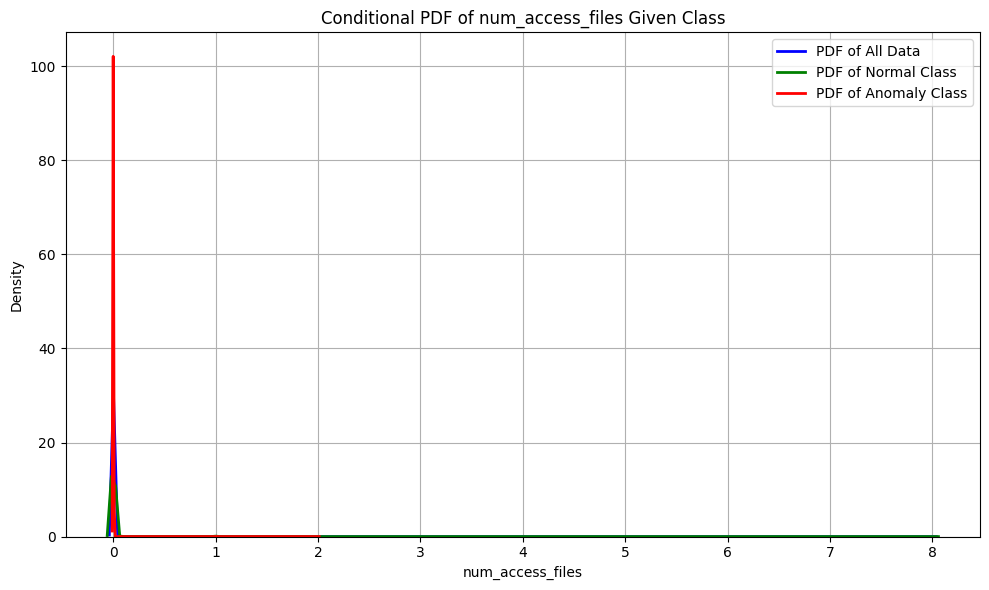

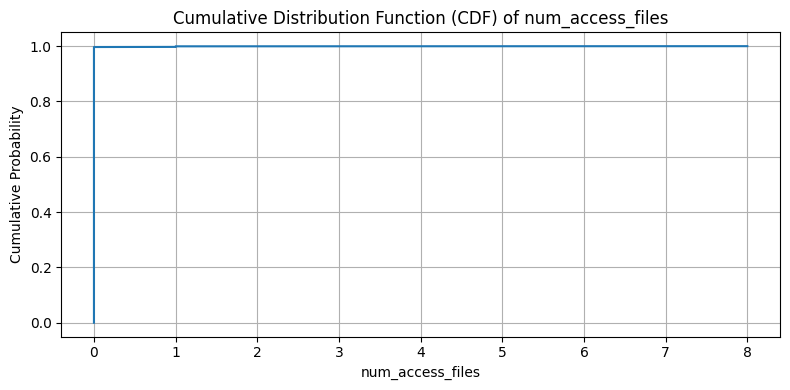

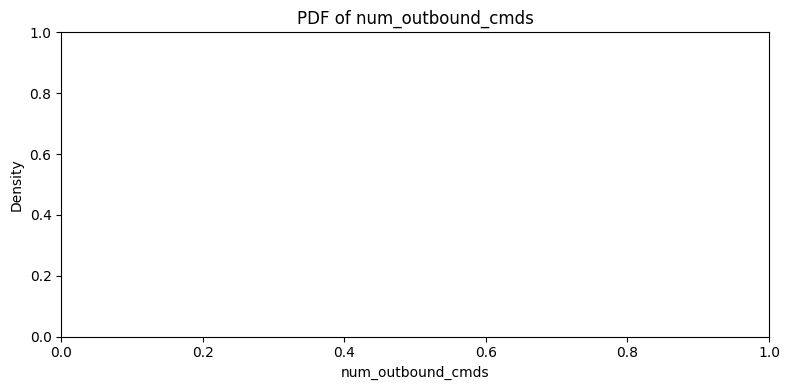

C:\Users\Youssef-Gerges\AppData\Local\Temp\ipykernel_36656\2674463146.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # This will now have the correct entries


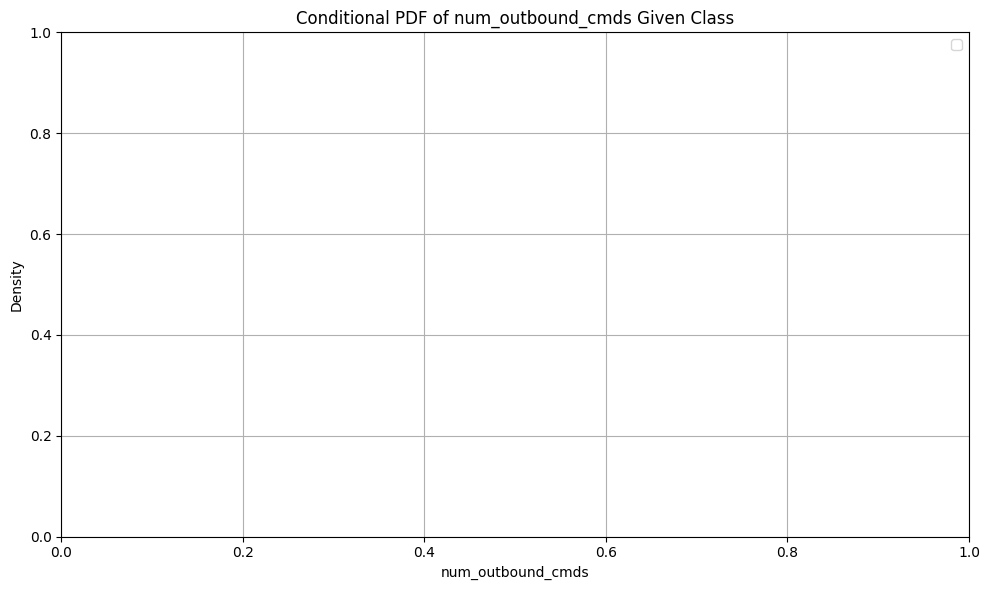

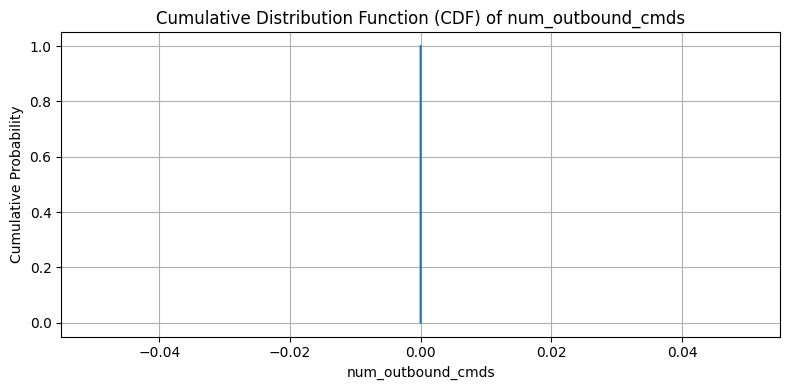

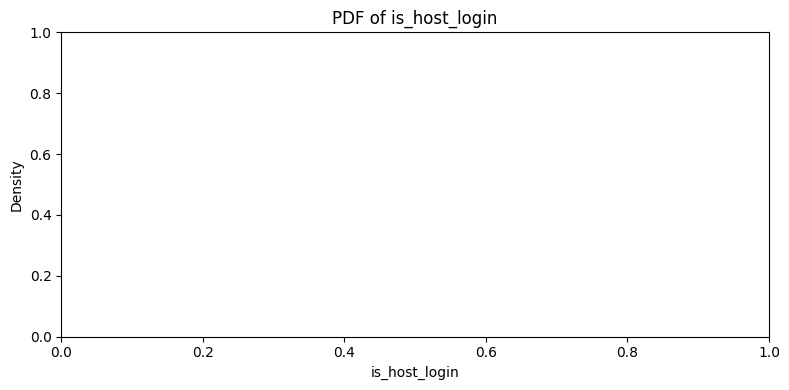

C:\Users\Youssef-Gerges\AppData\Local\Temp\ipykernel_36656\2674463146.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # This will now have the correct entries


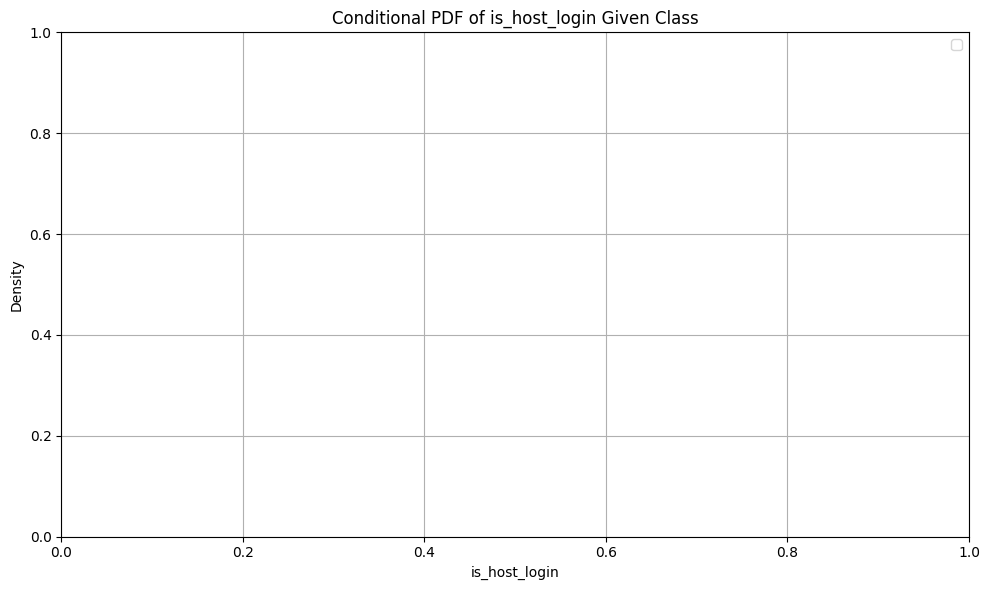

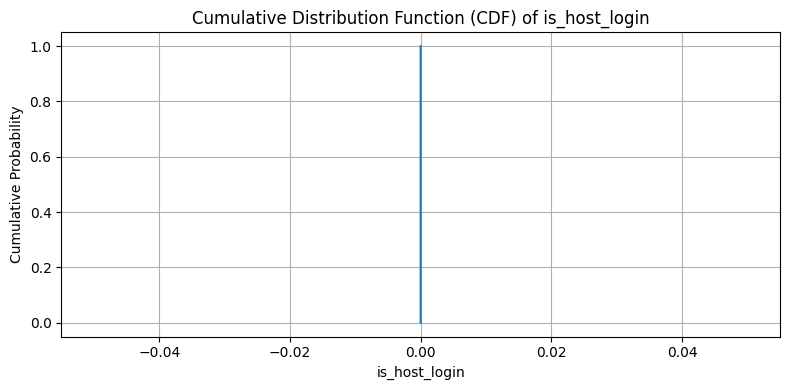

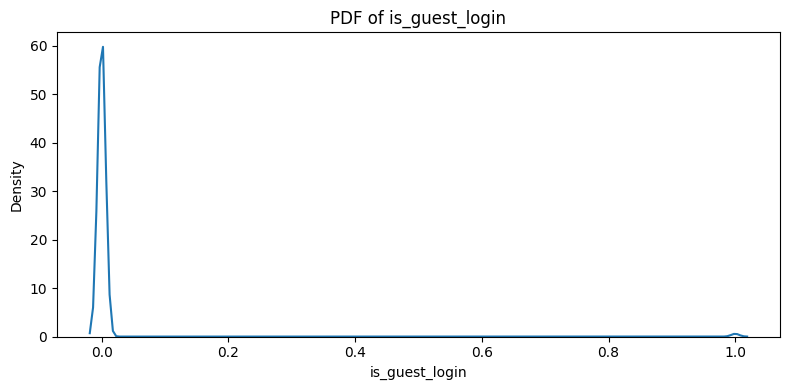

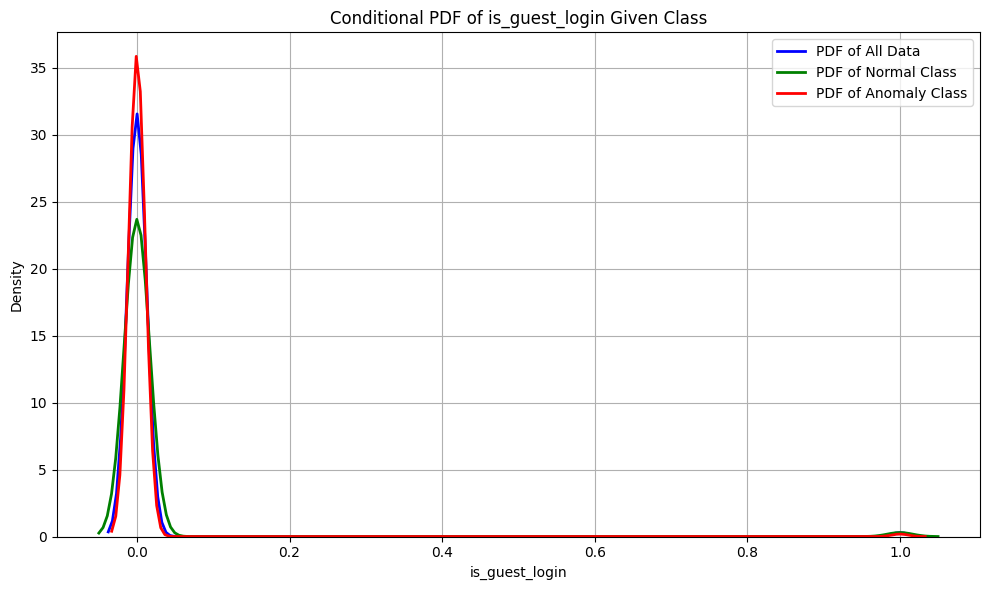

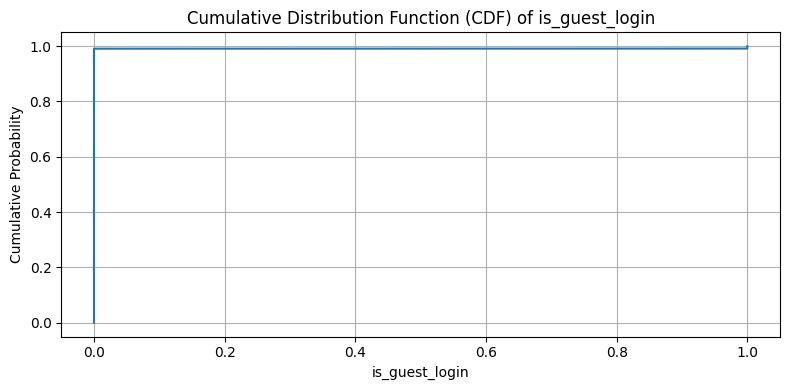

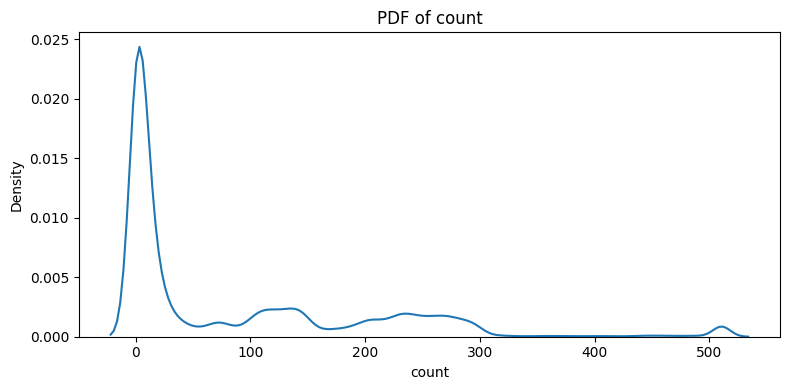

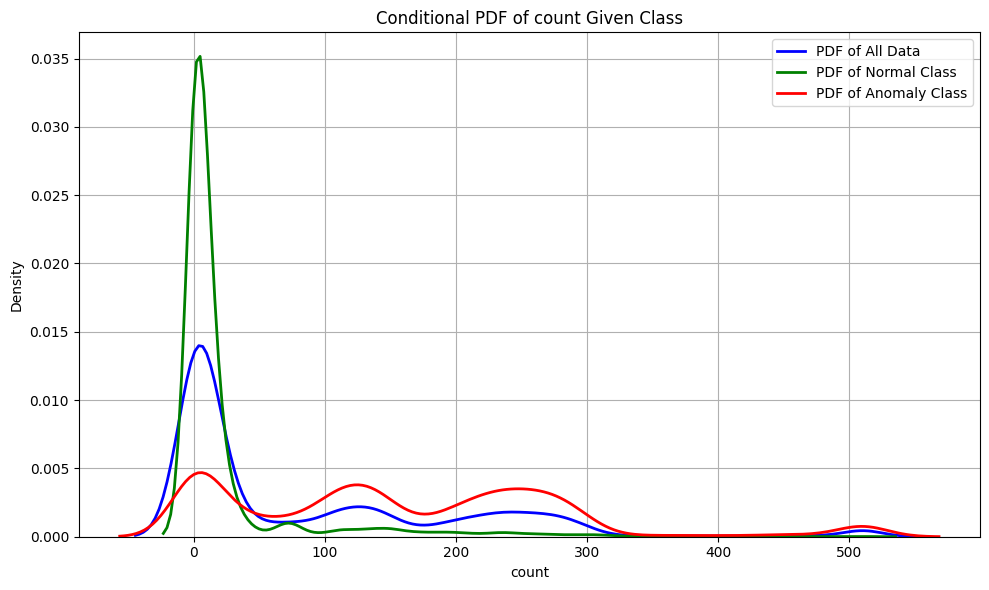

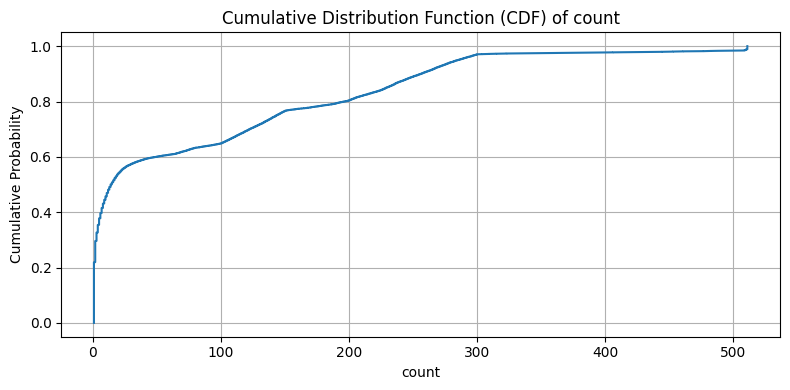

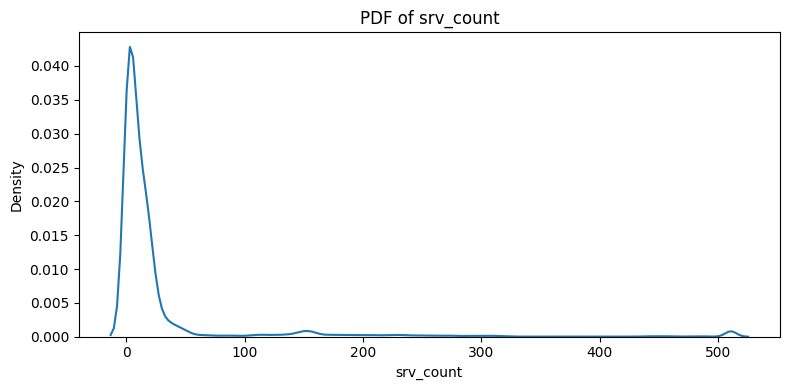

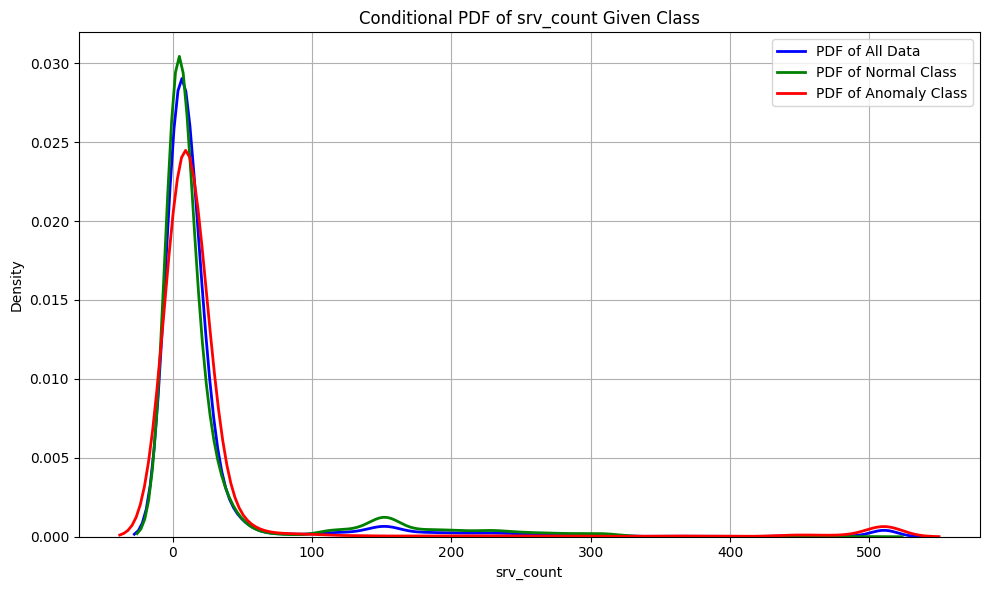

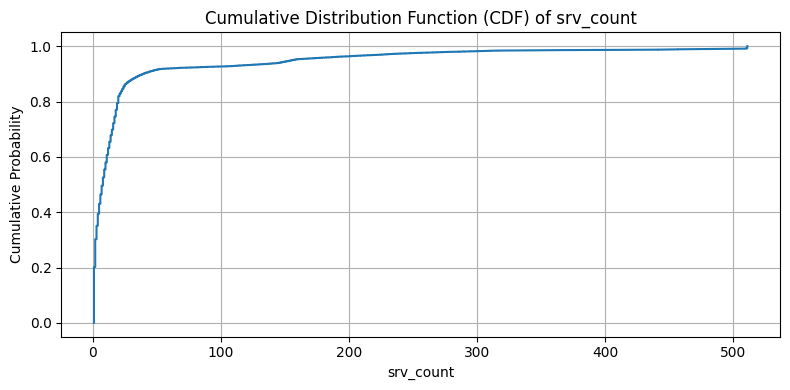

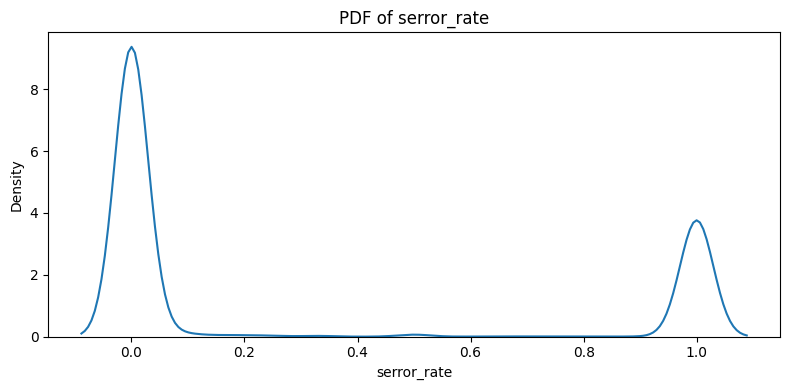

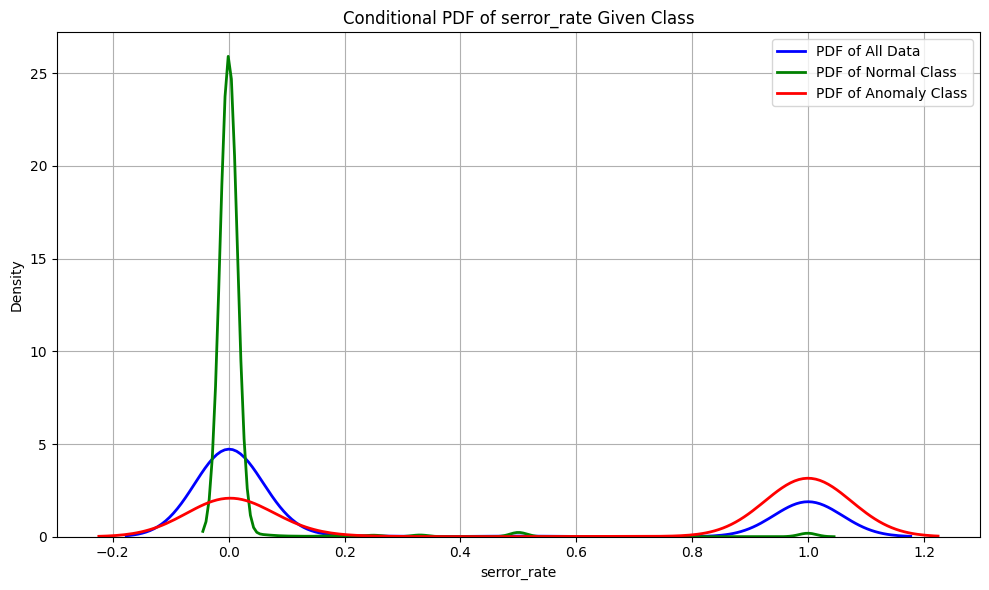

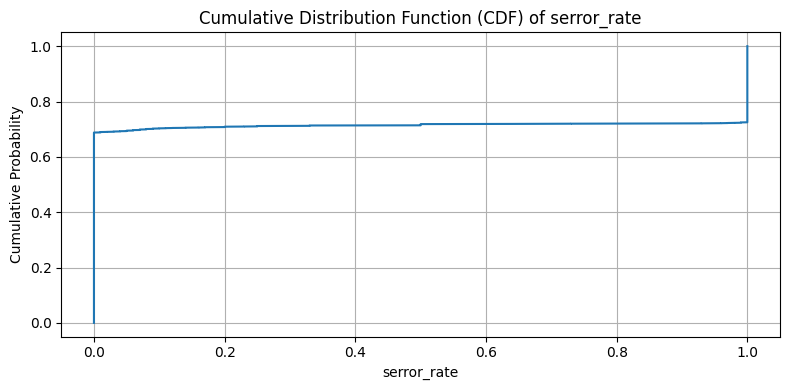

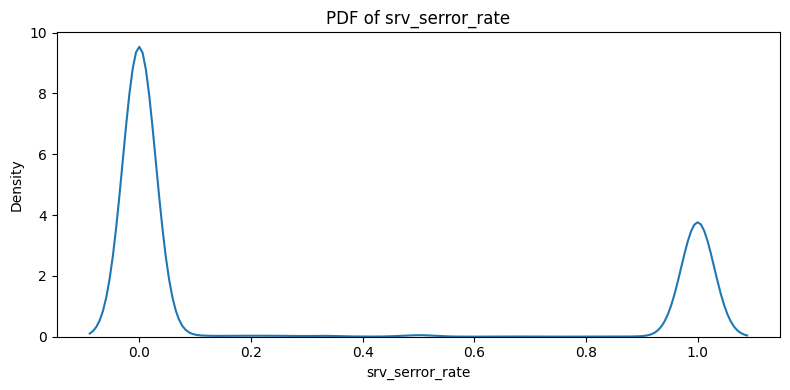

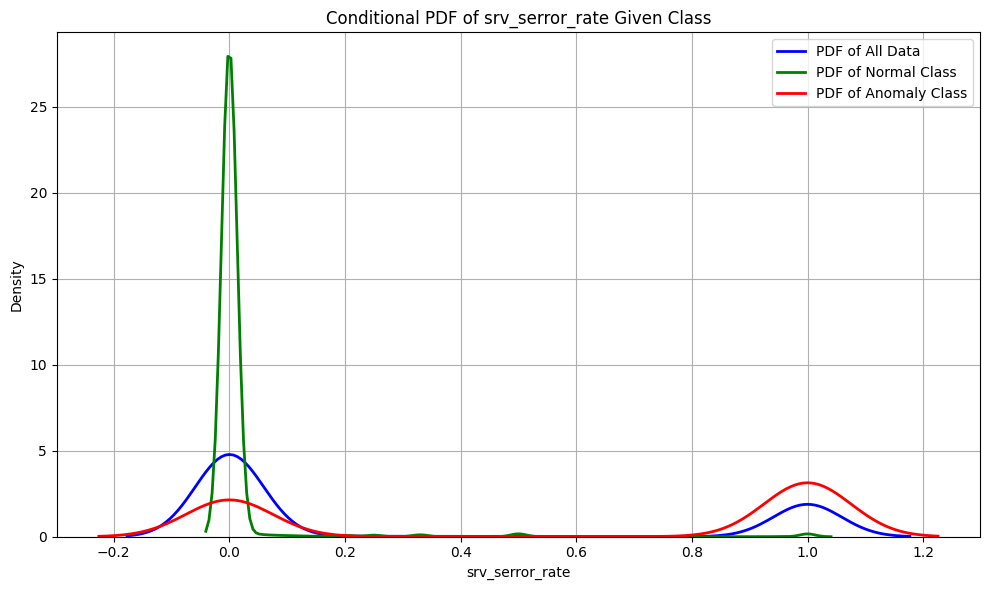

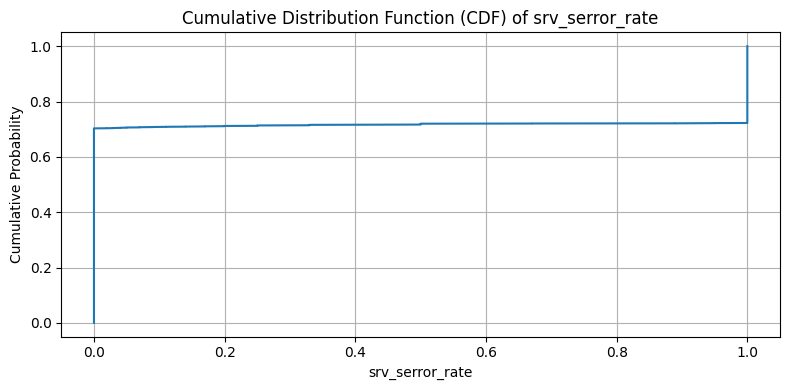

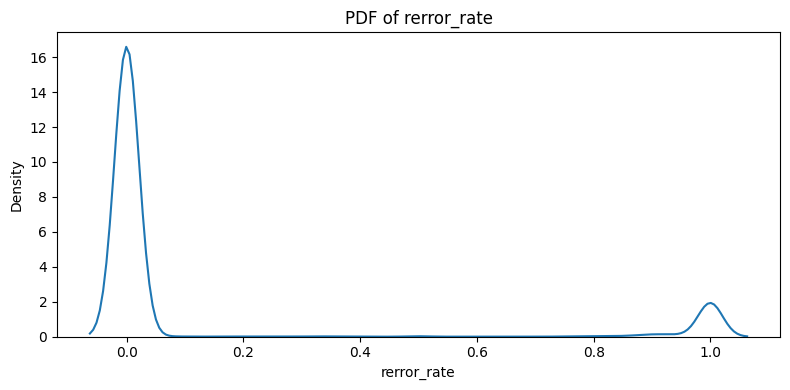

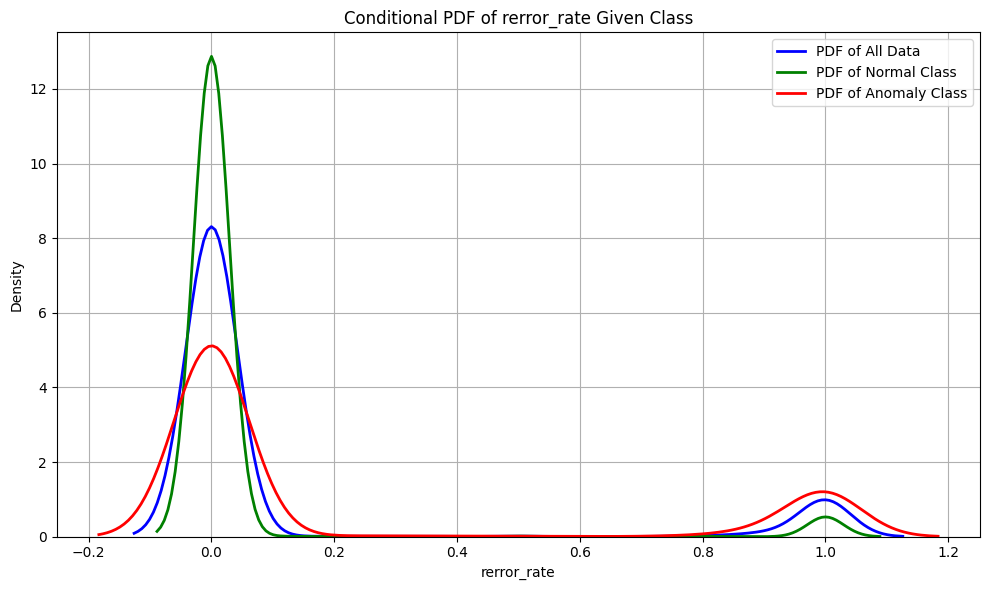

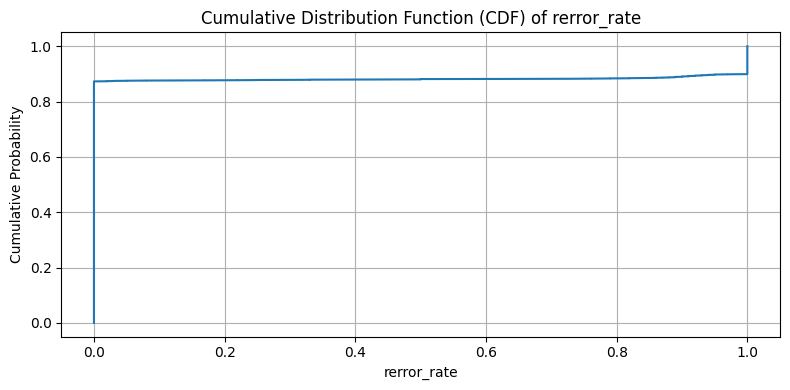

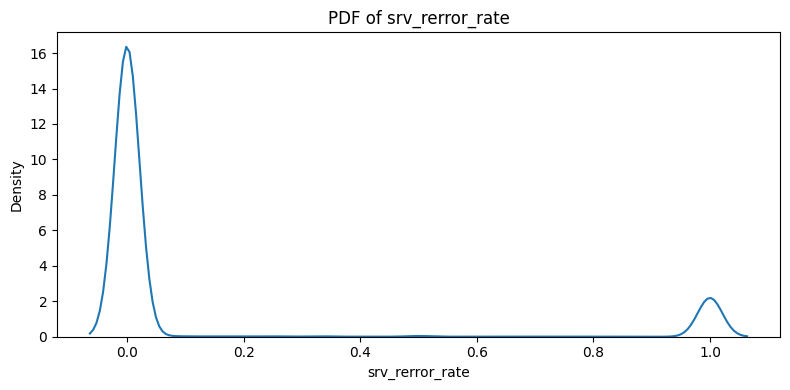

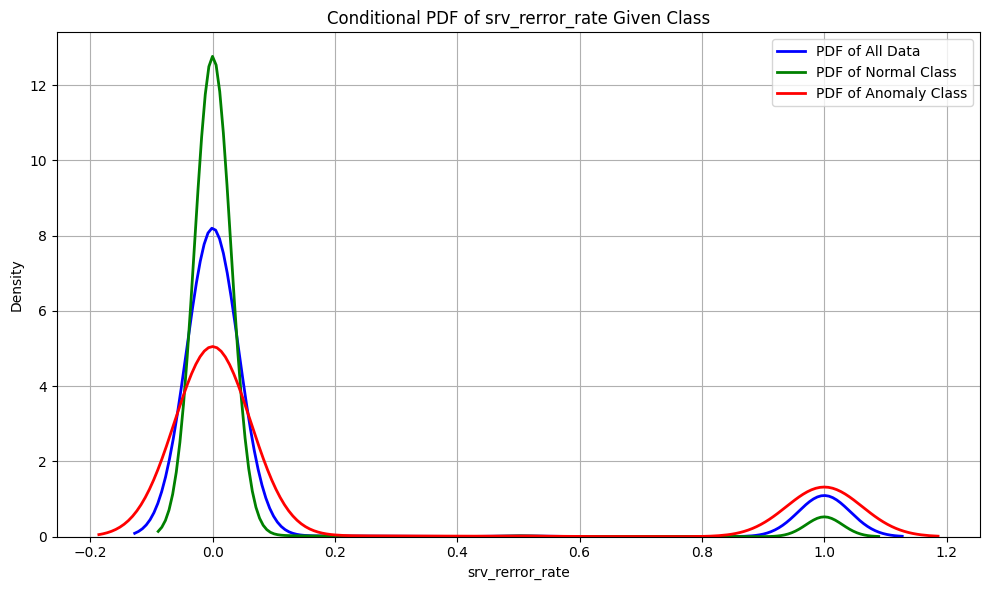

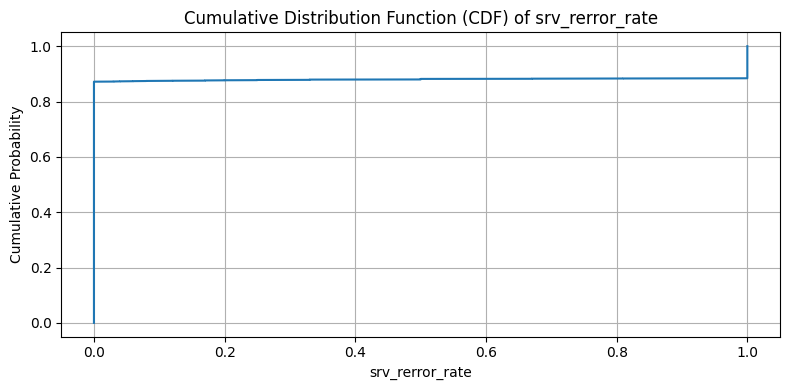

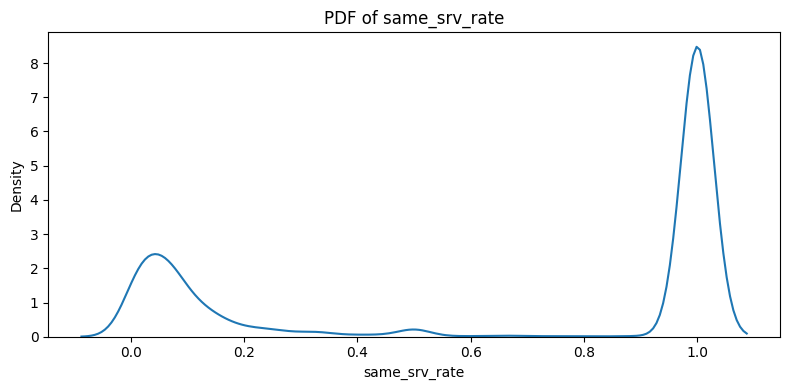

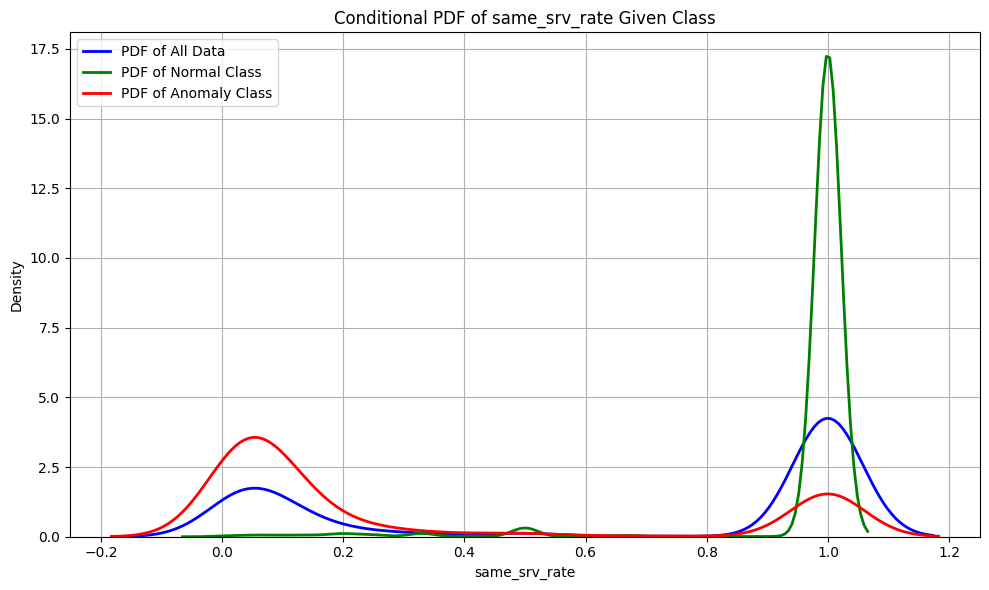

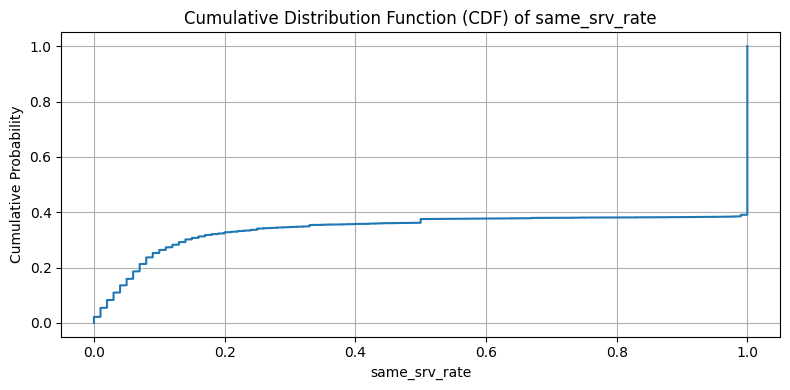

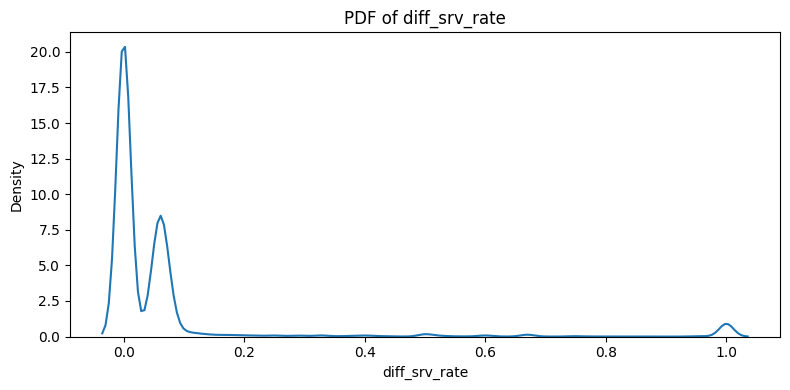

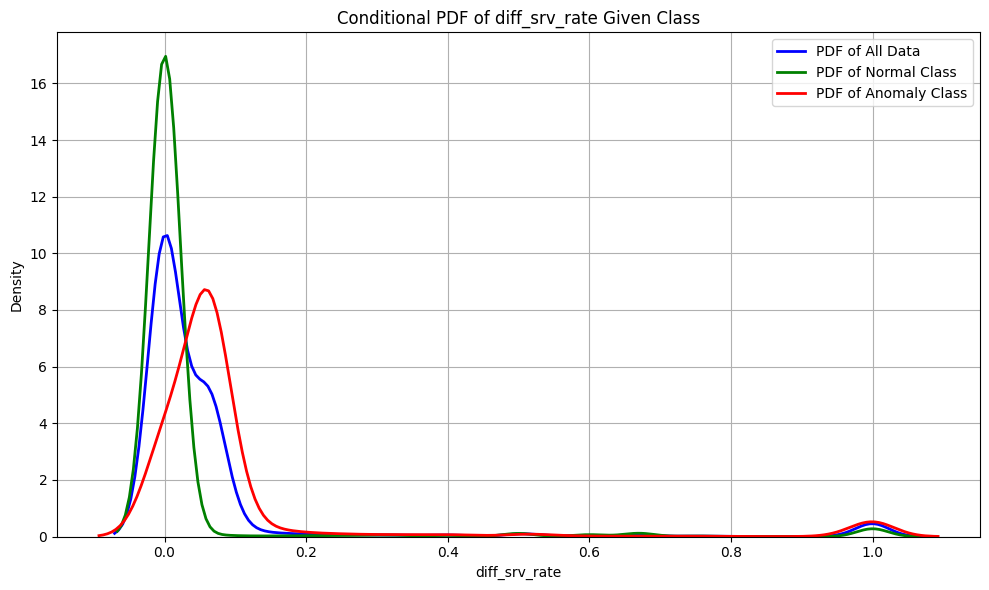

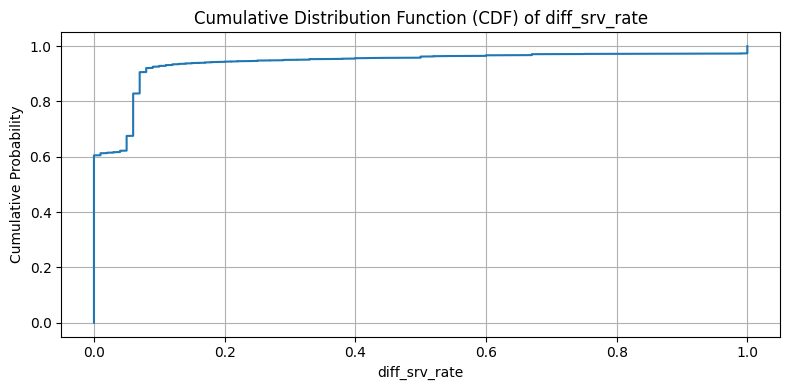

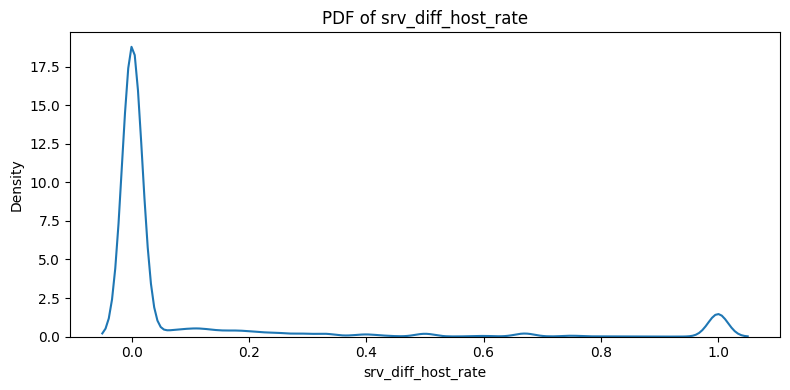

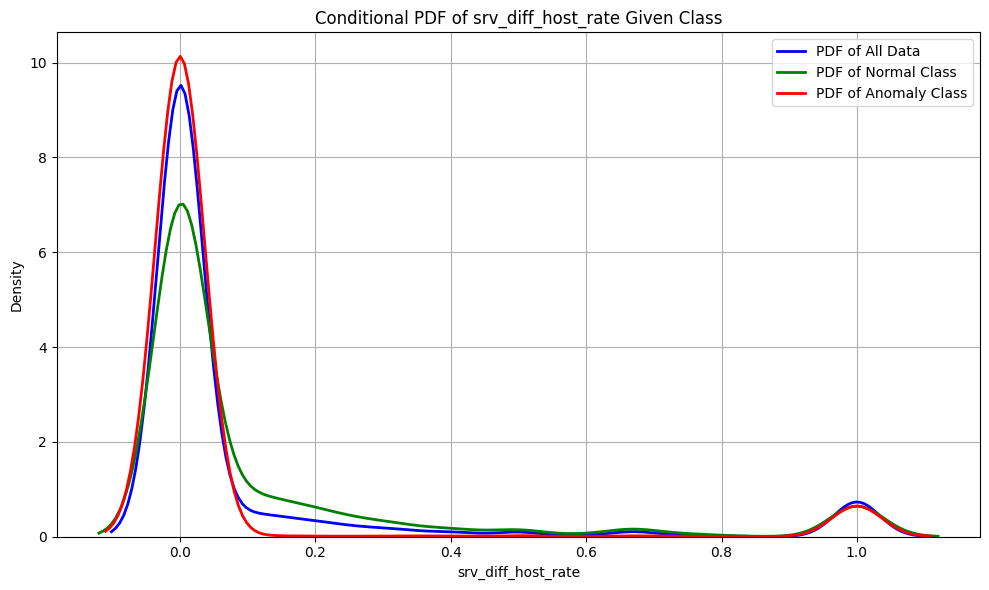

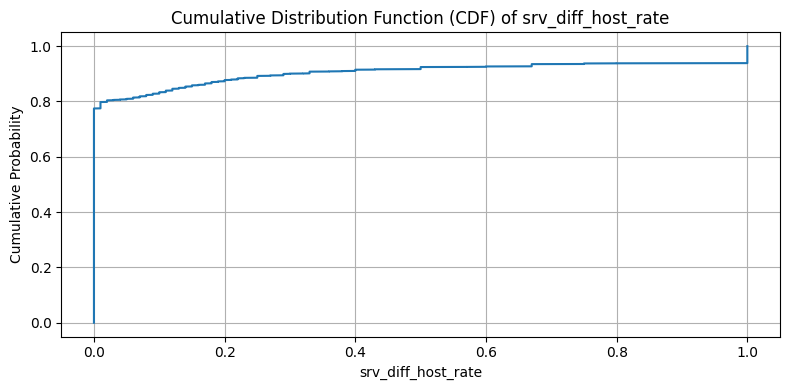

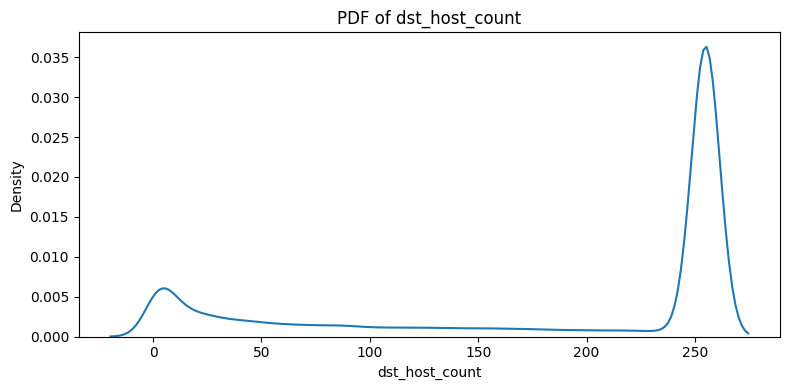

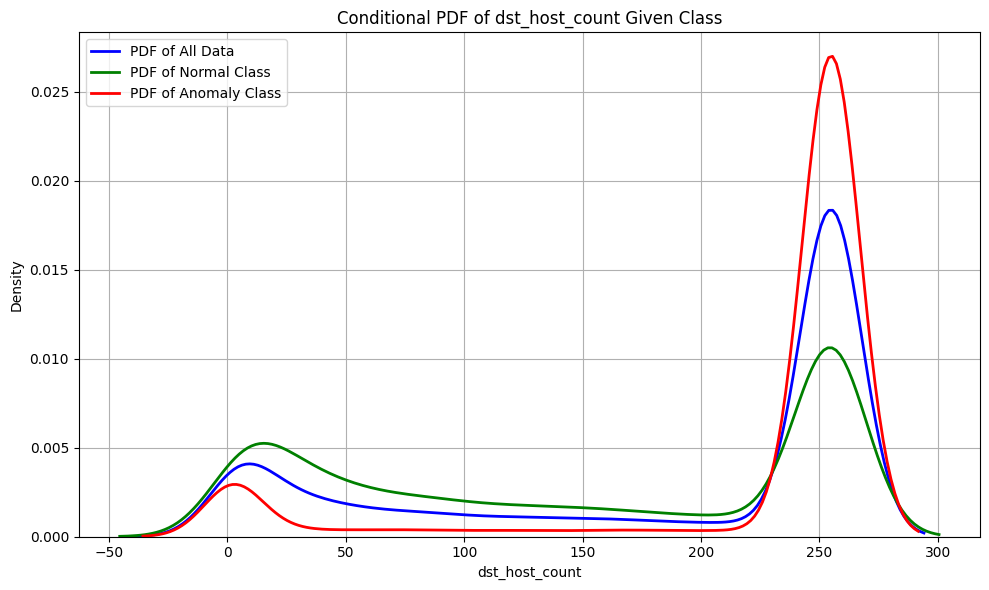

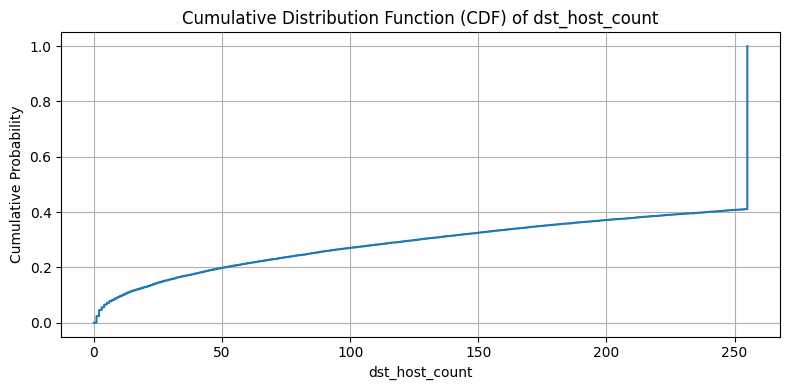

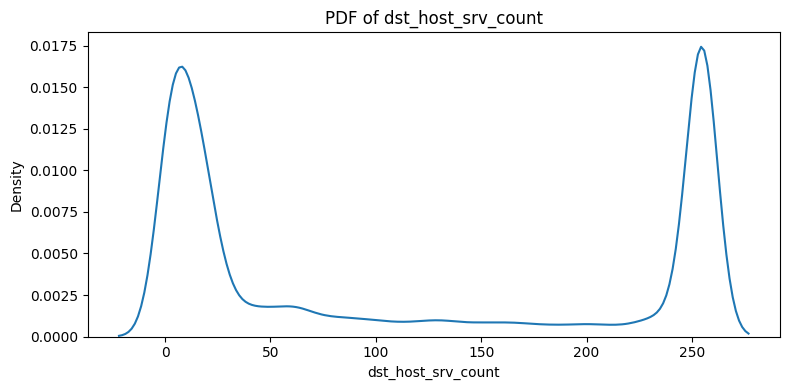

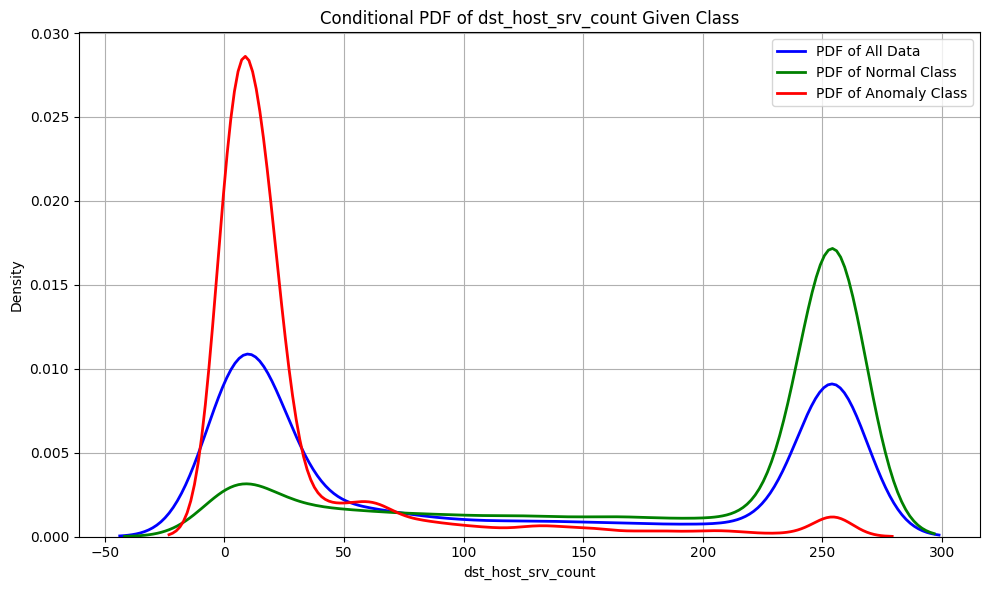

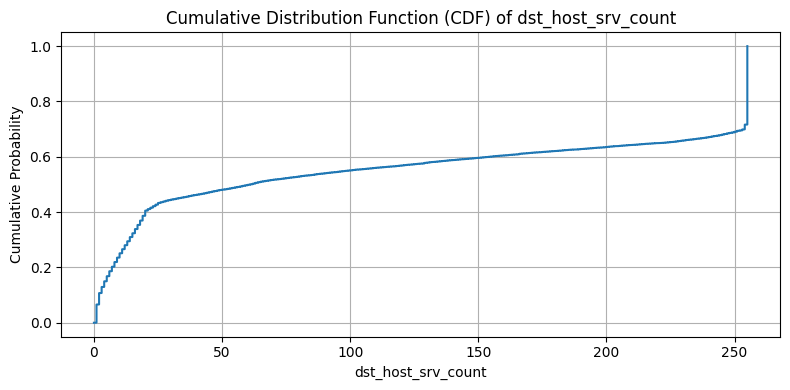

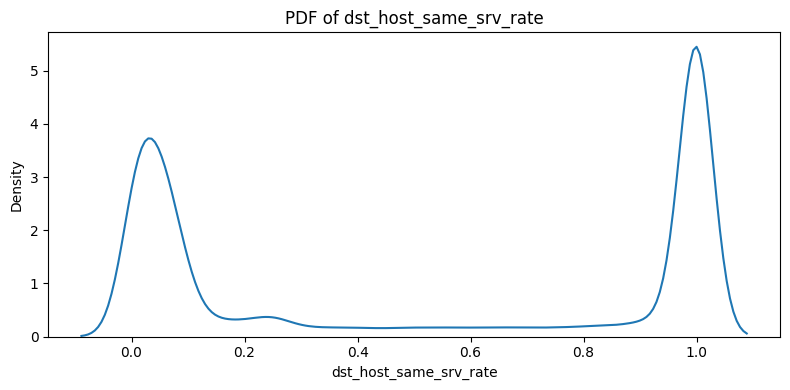

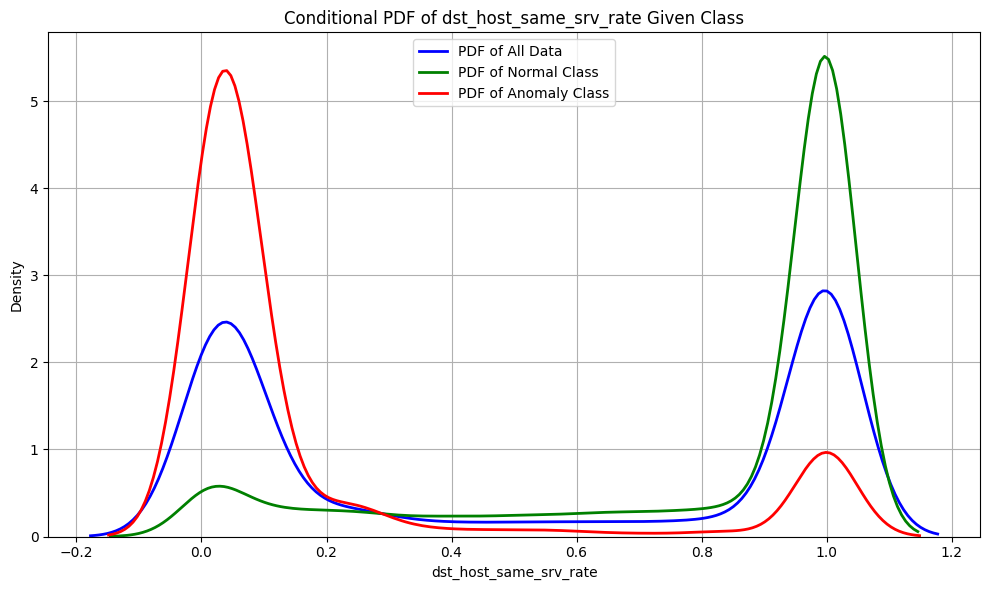

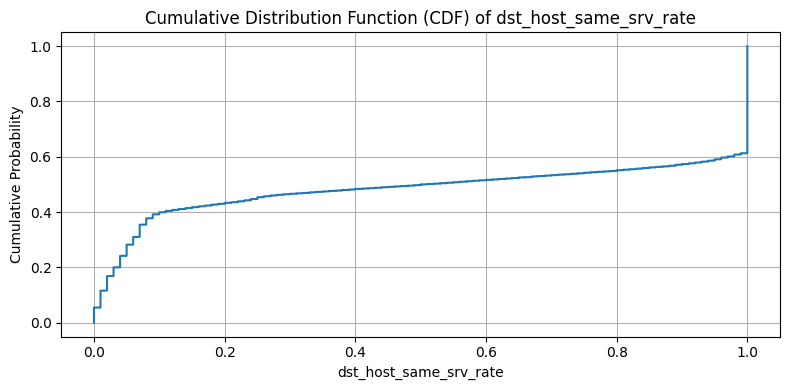

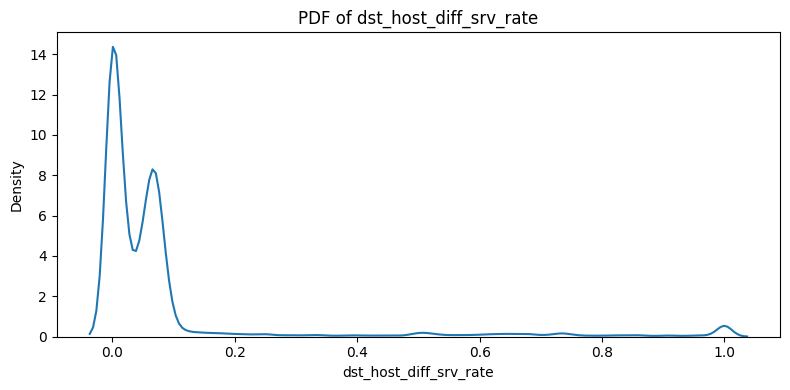

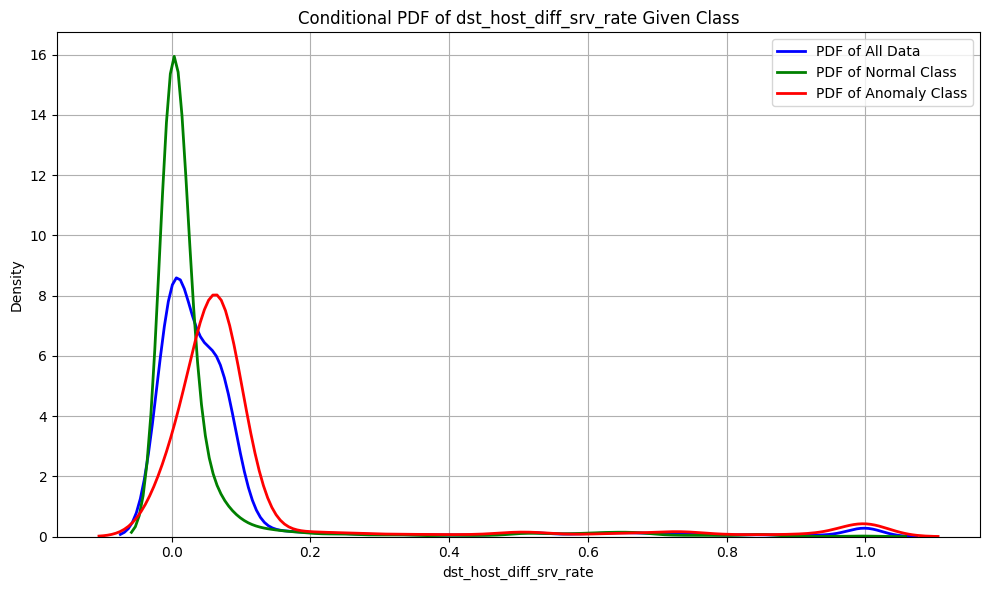

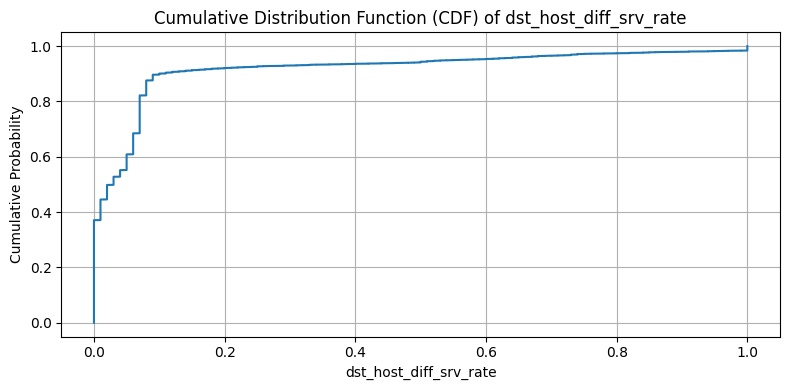

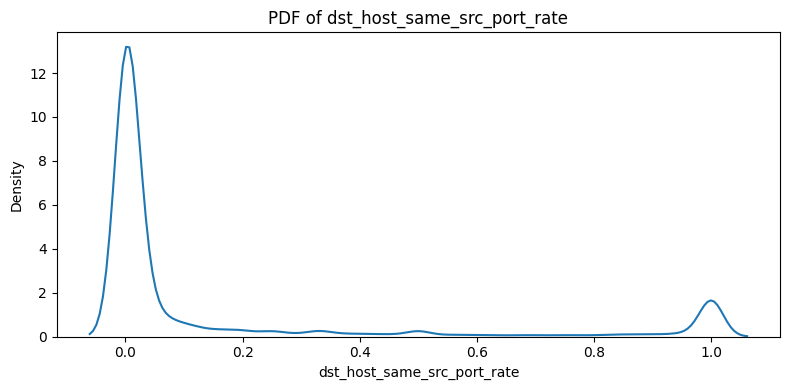

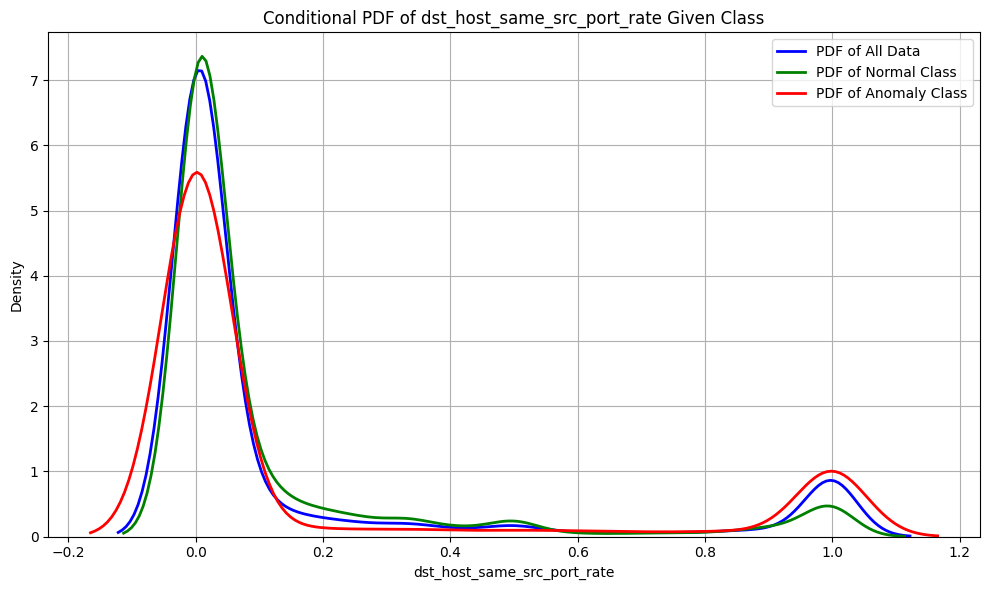

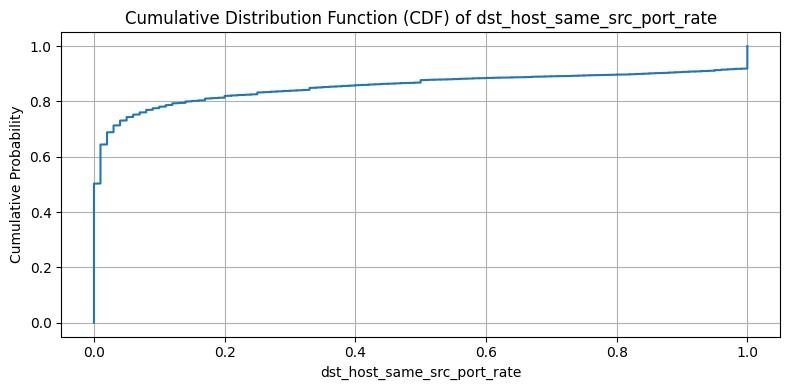

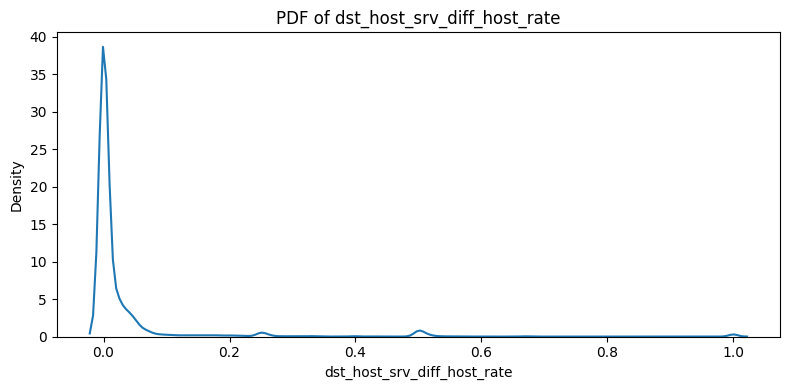

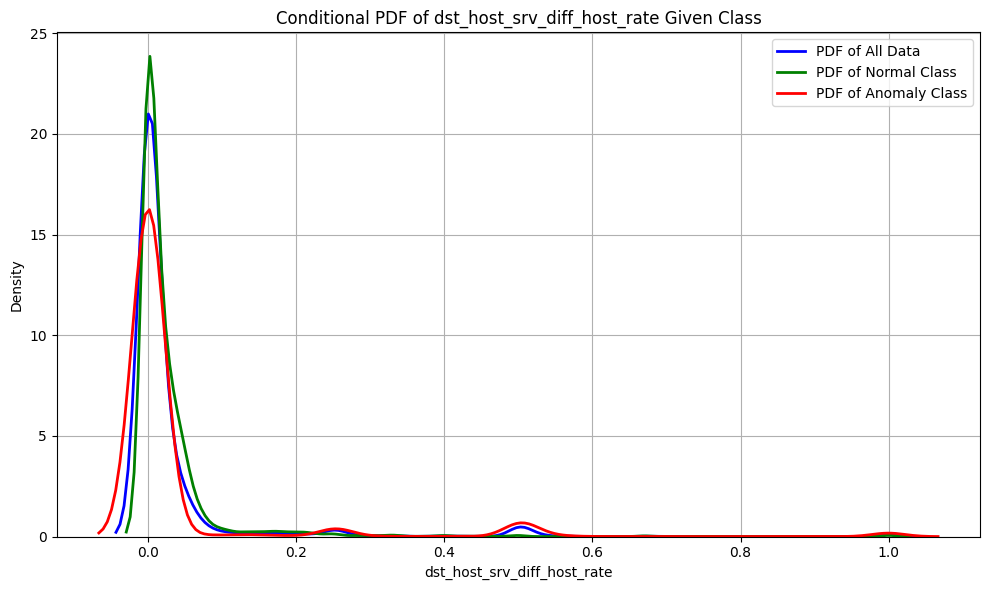

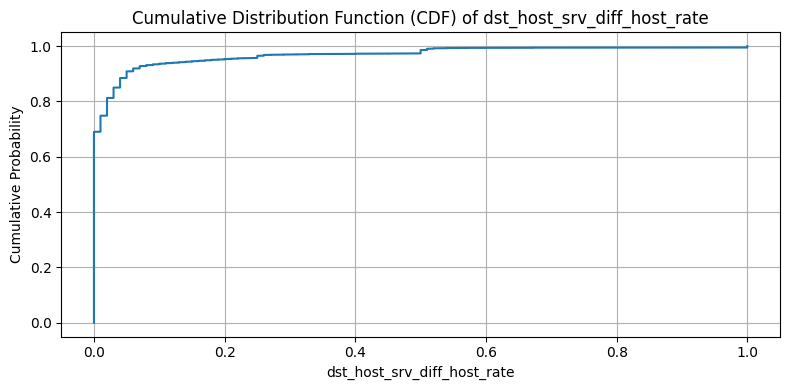

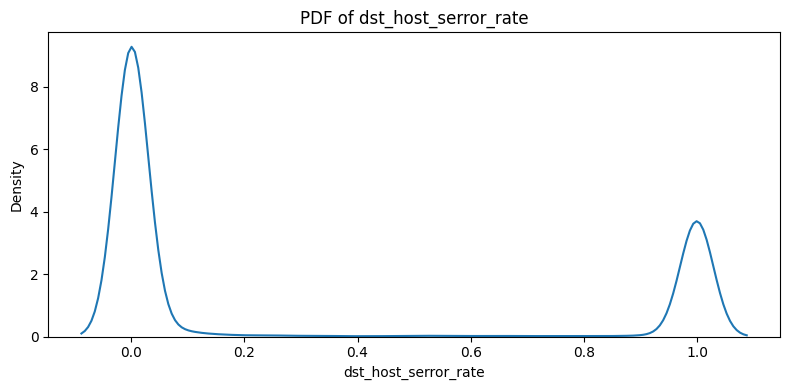

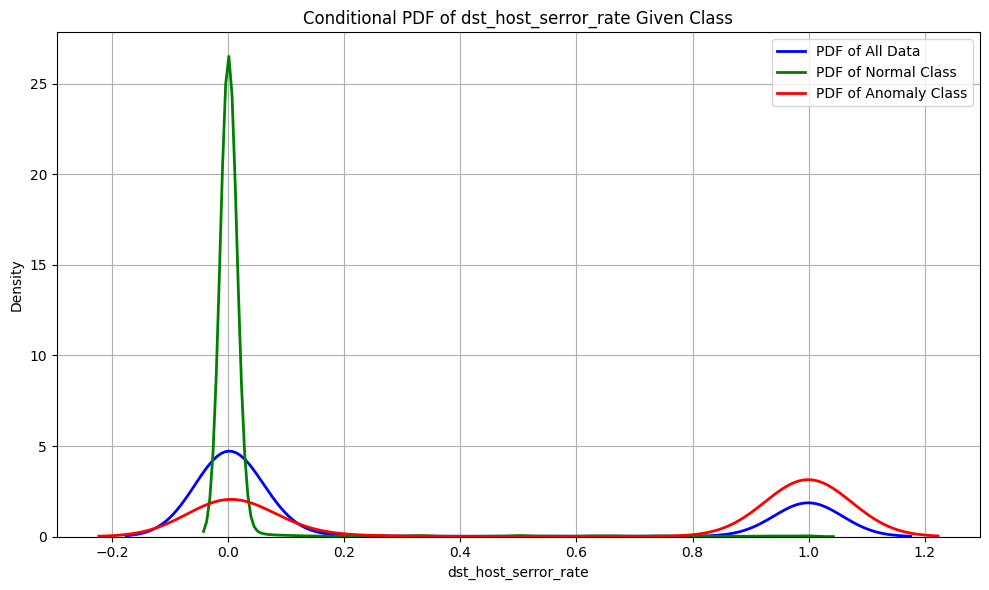

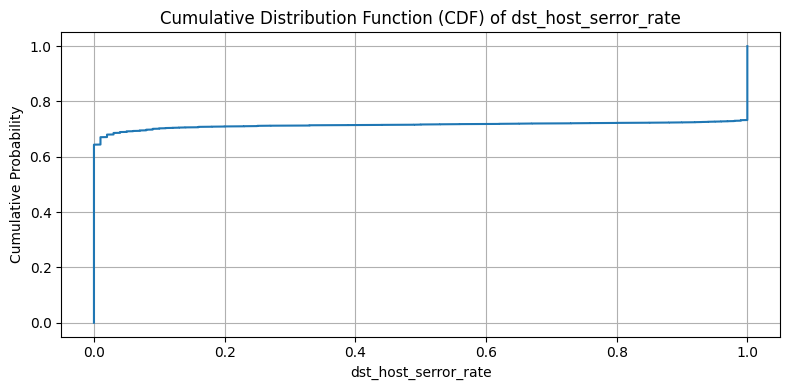

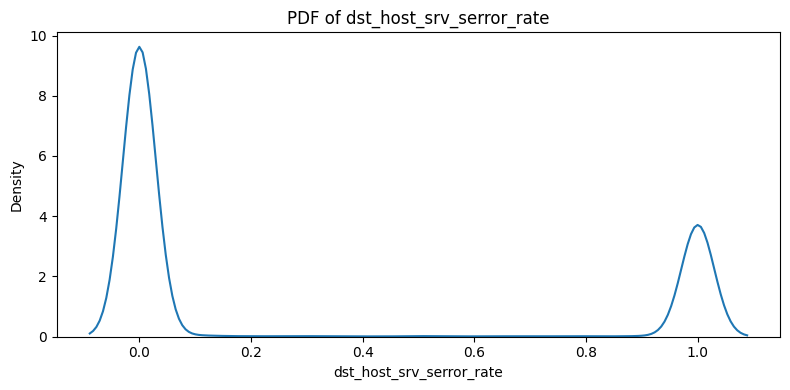

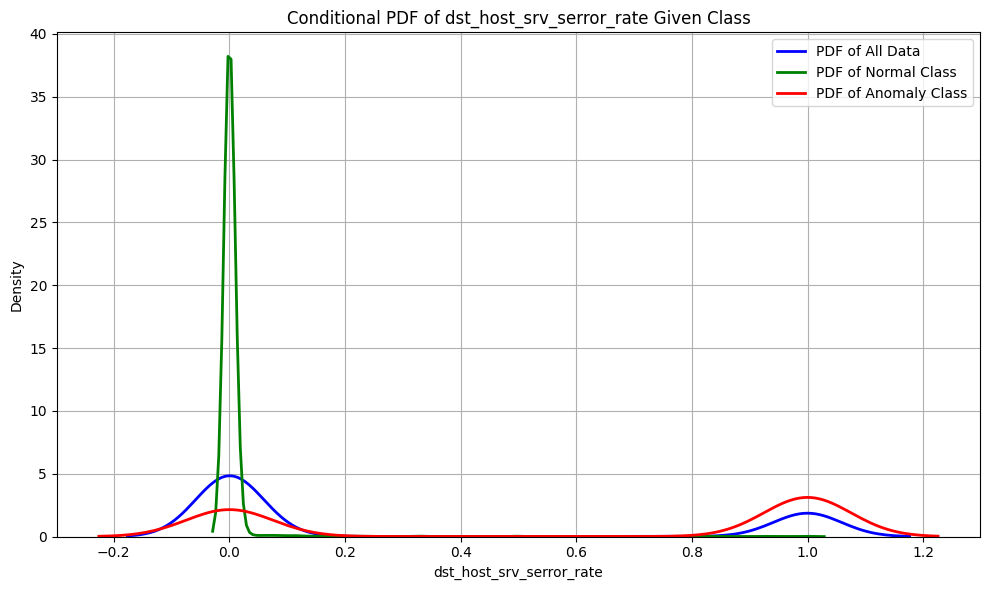

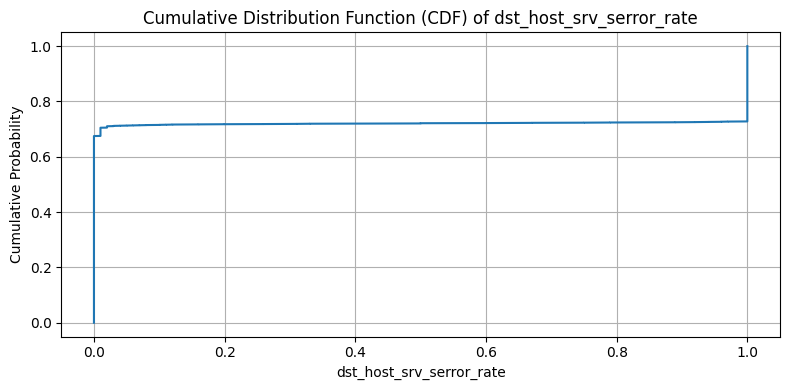

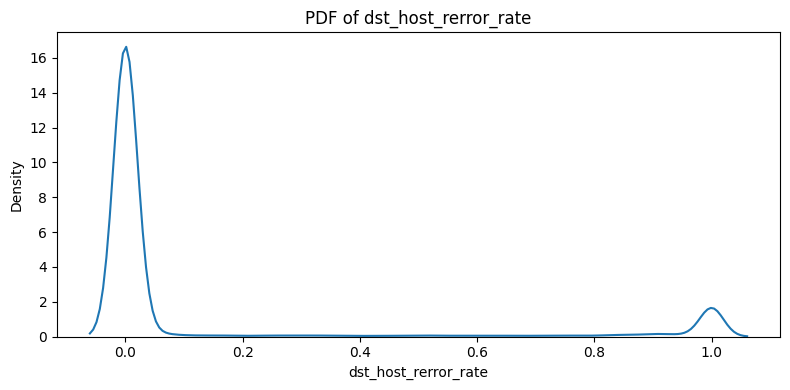

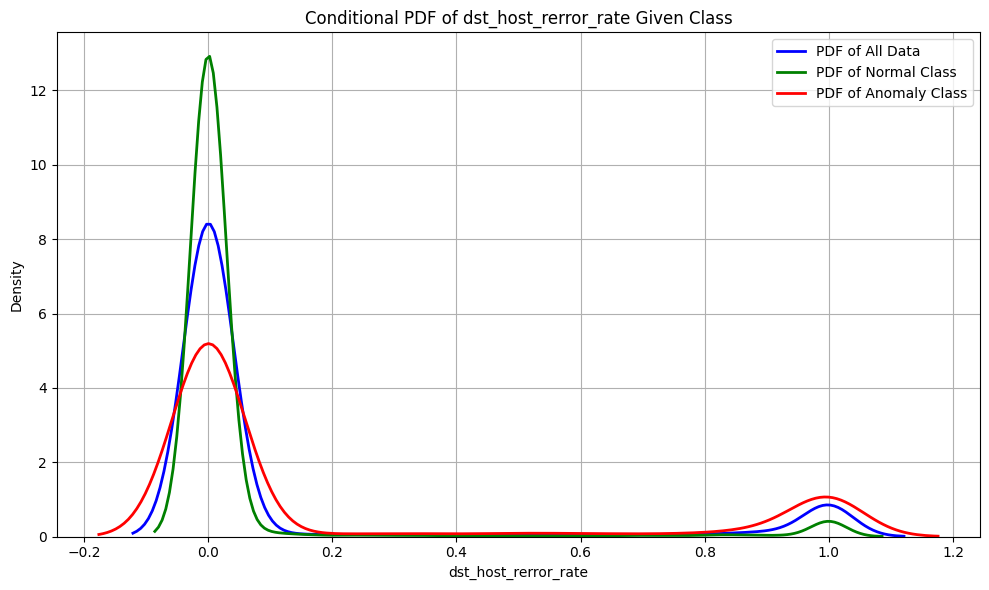

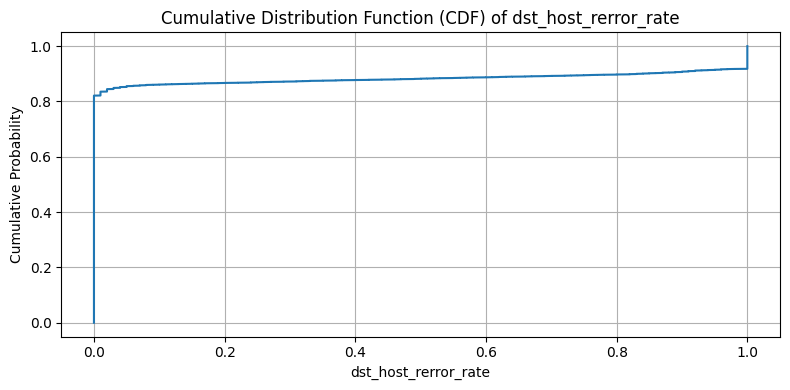

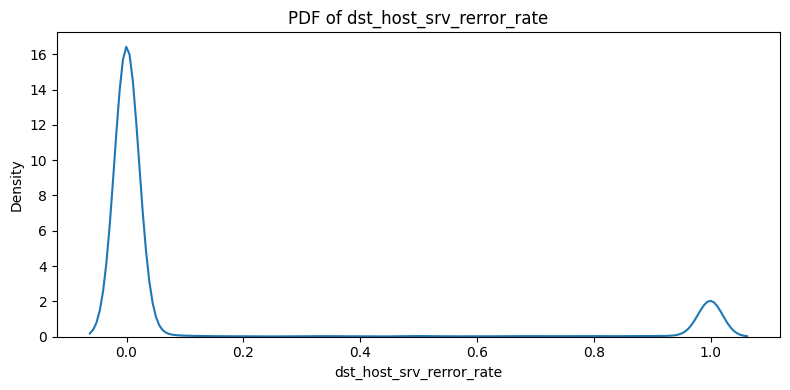

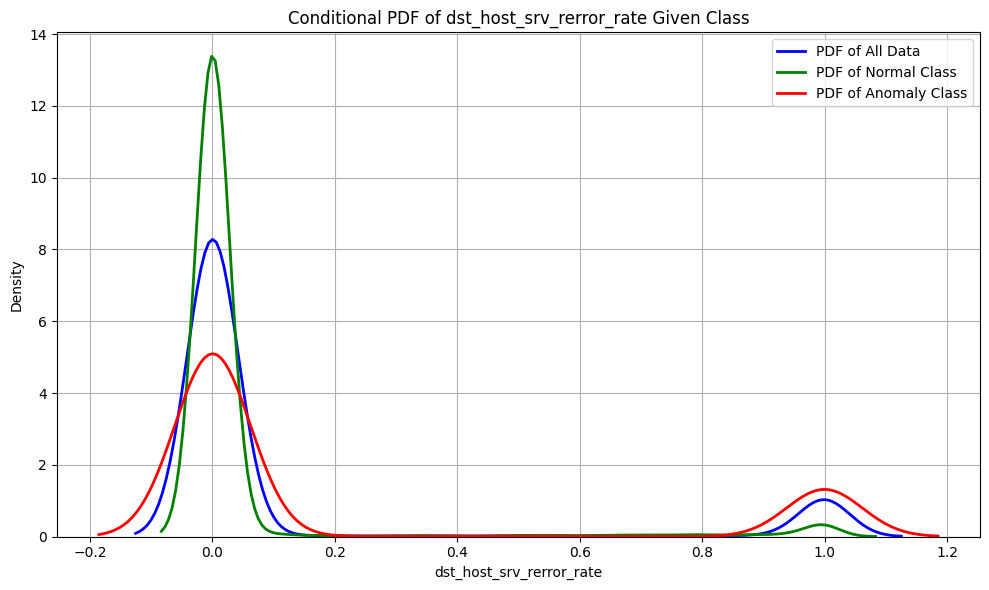

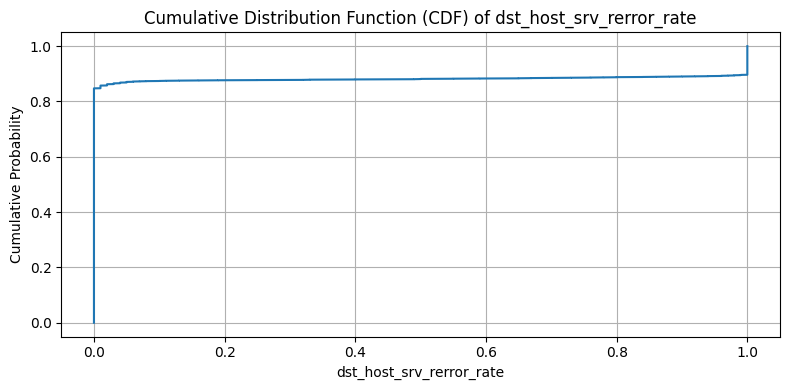

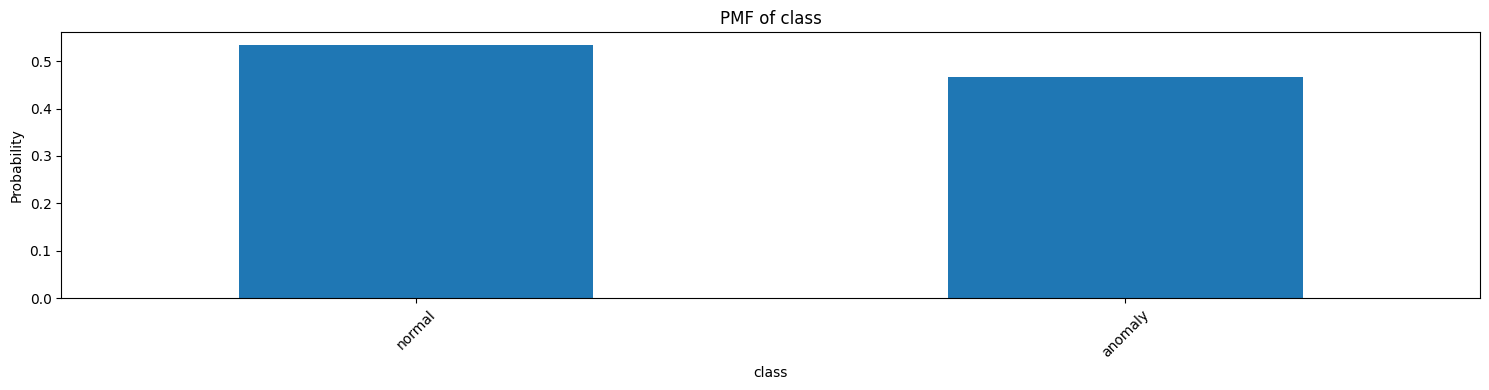

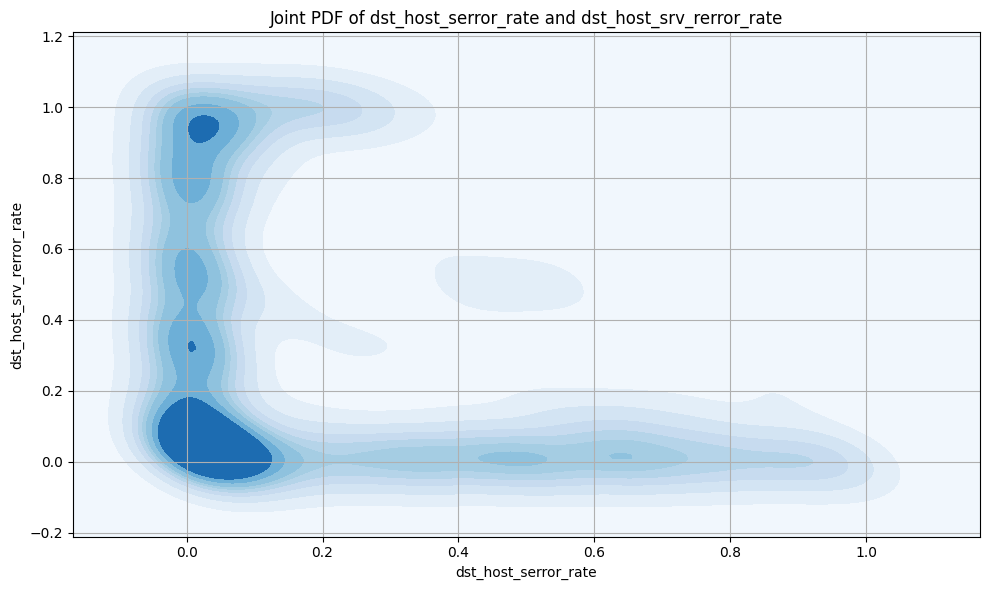

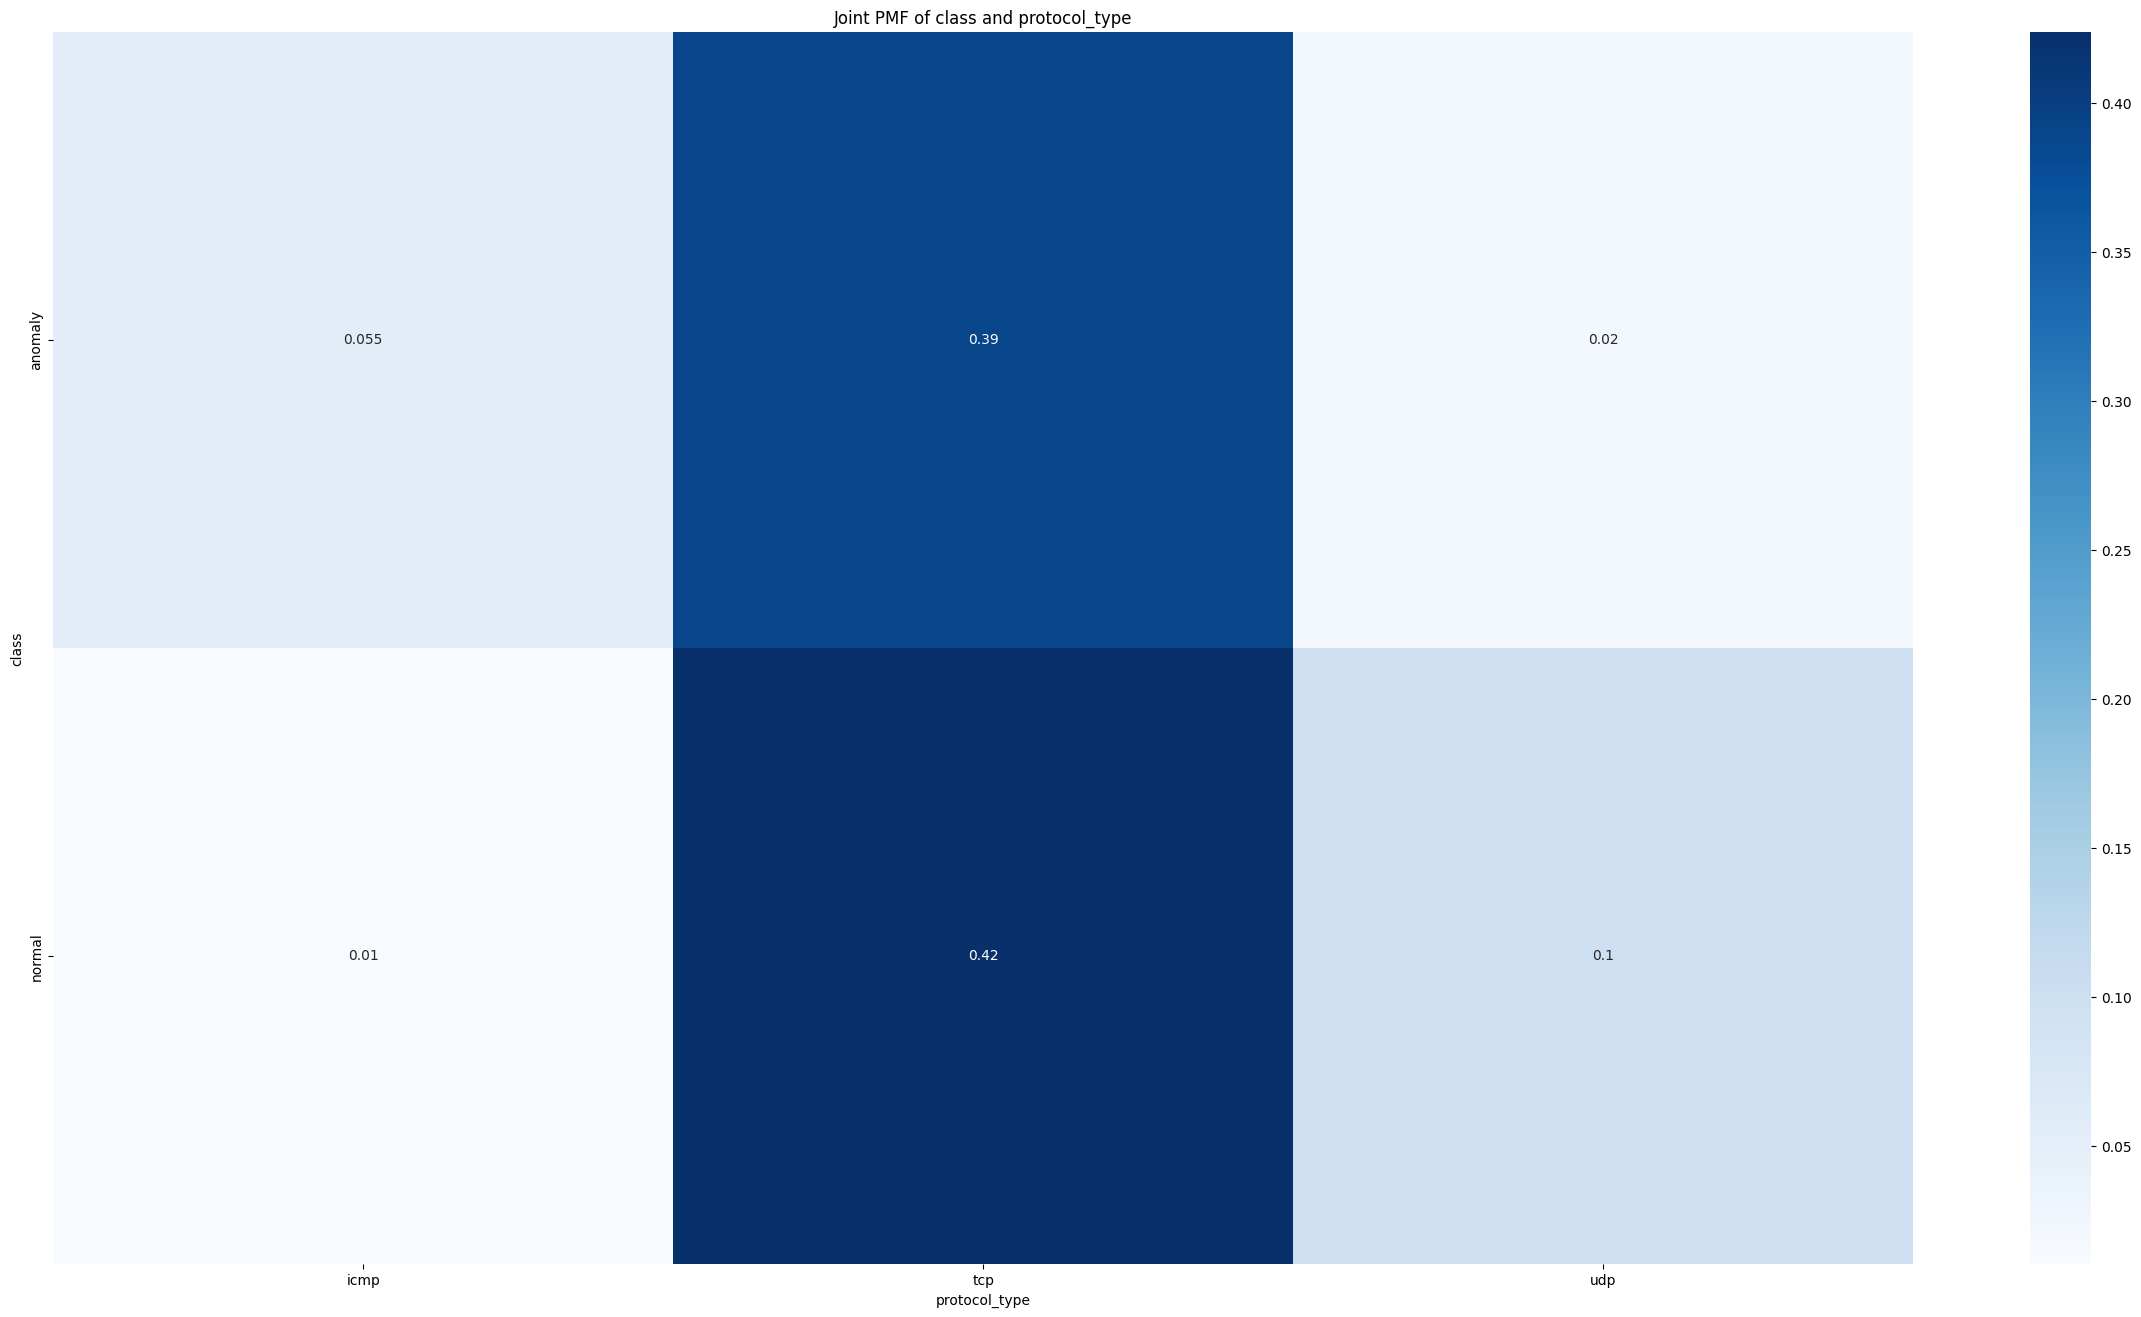

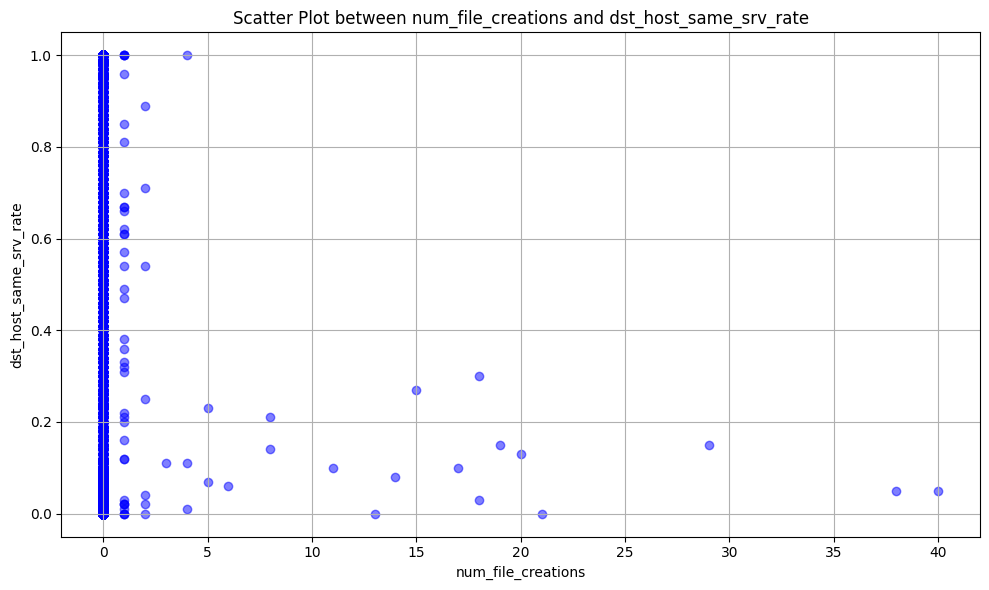

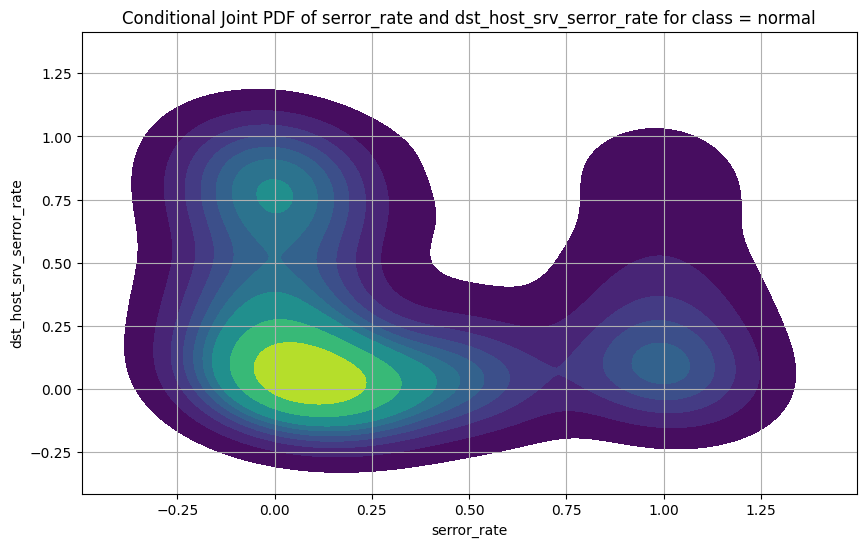

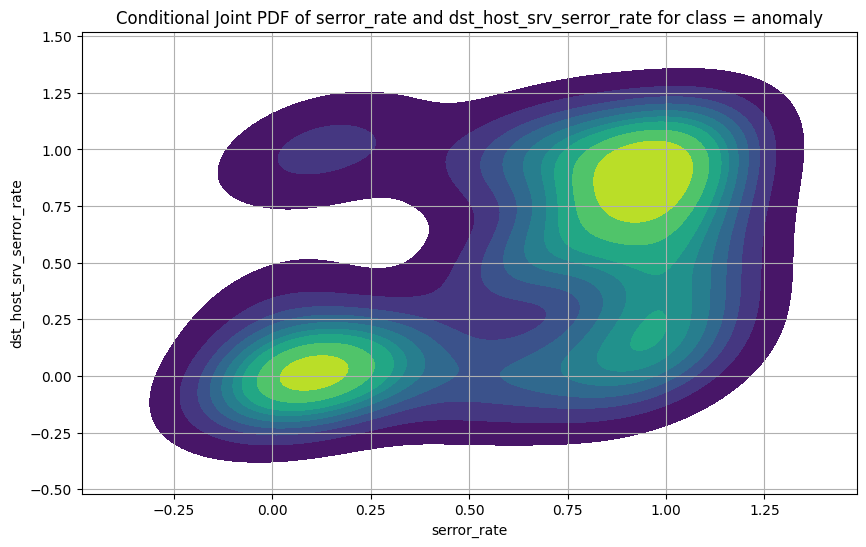

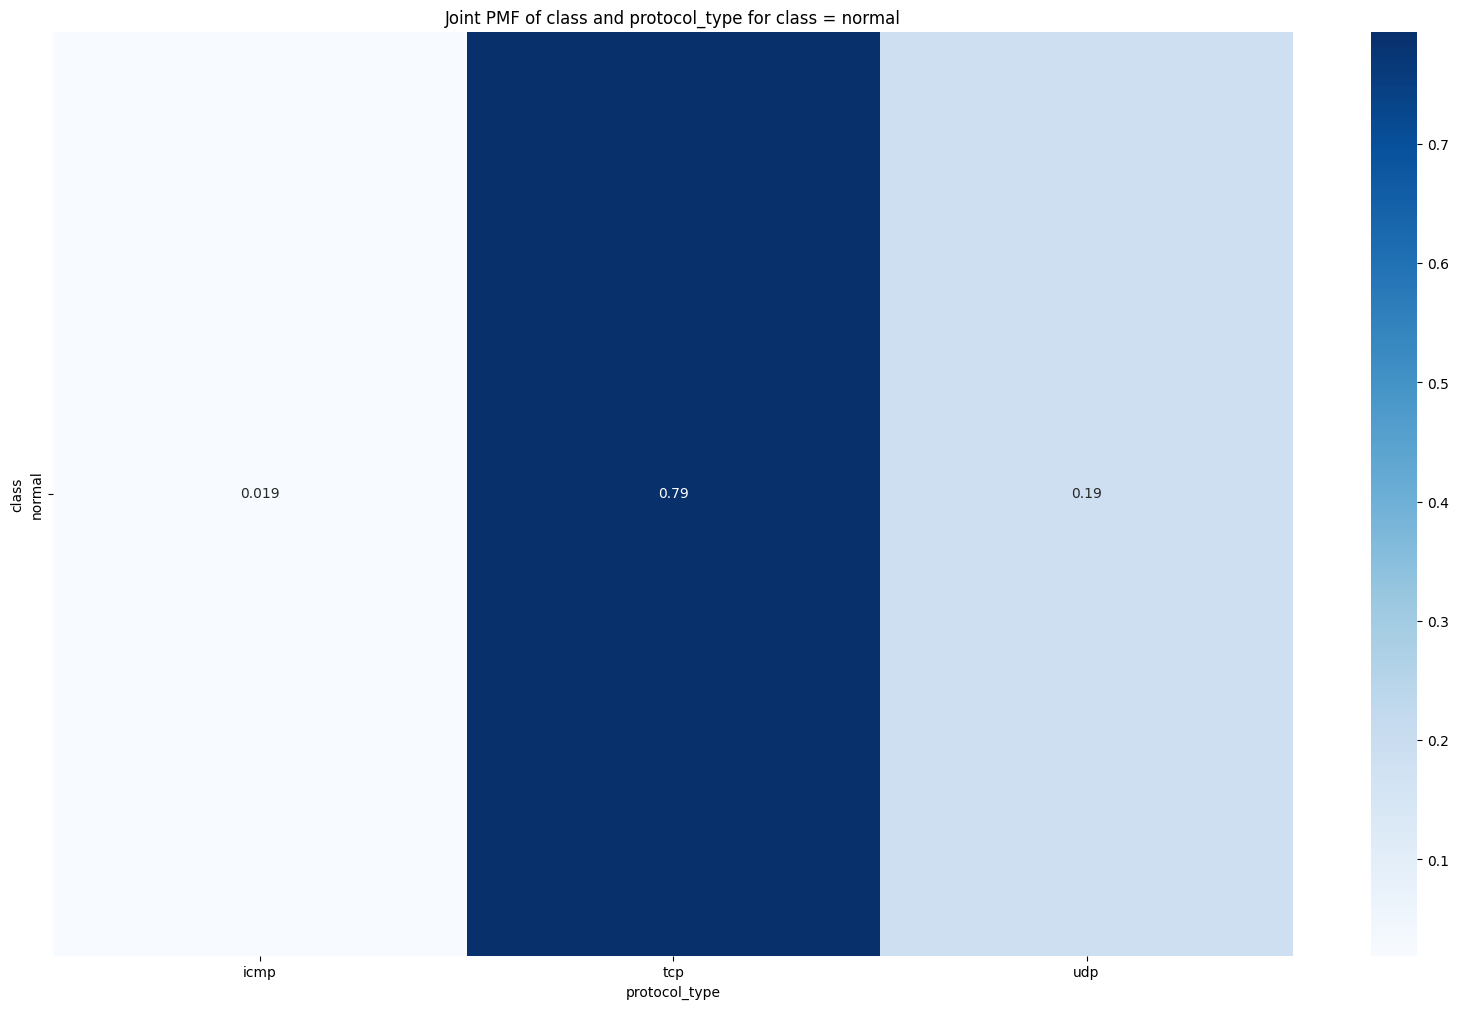

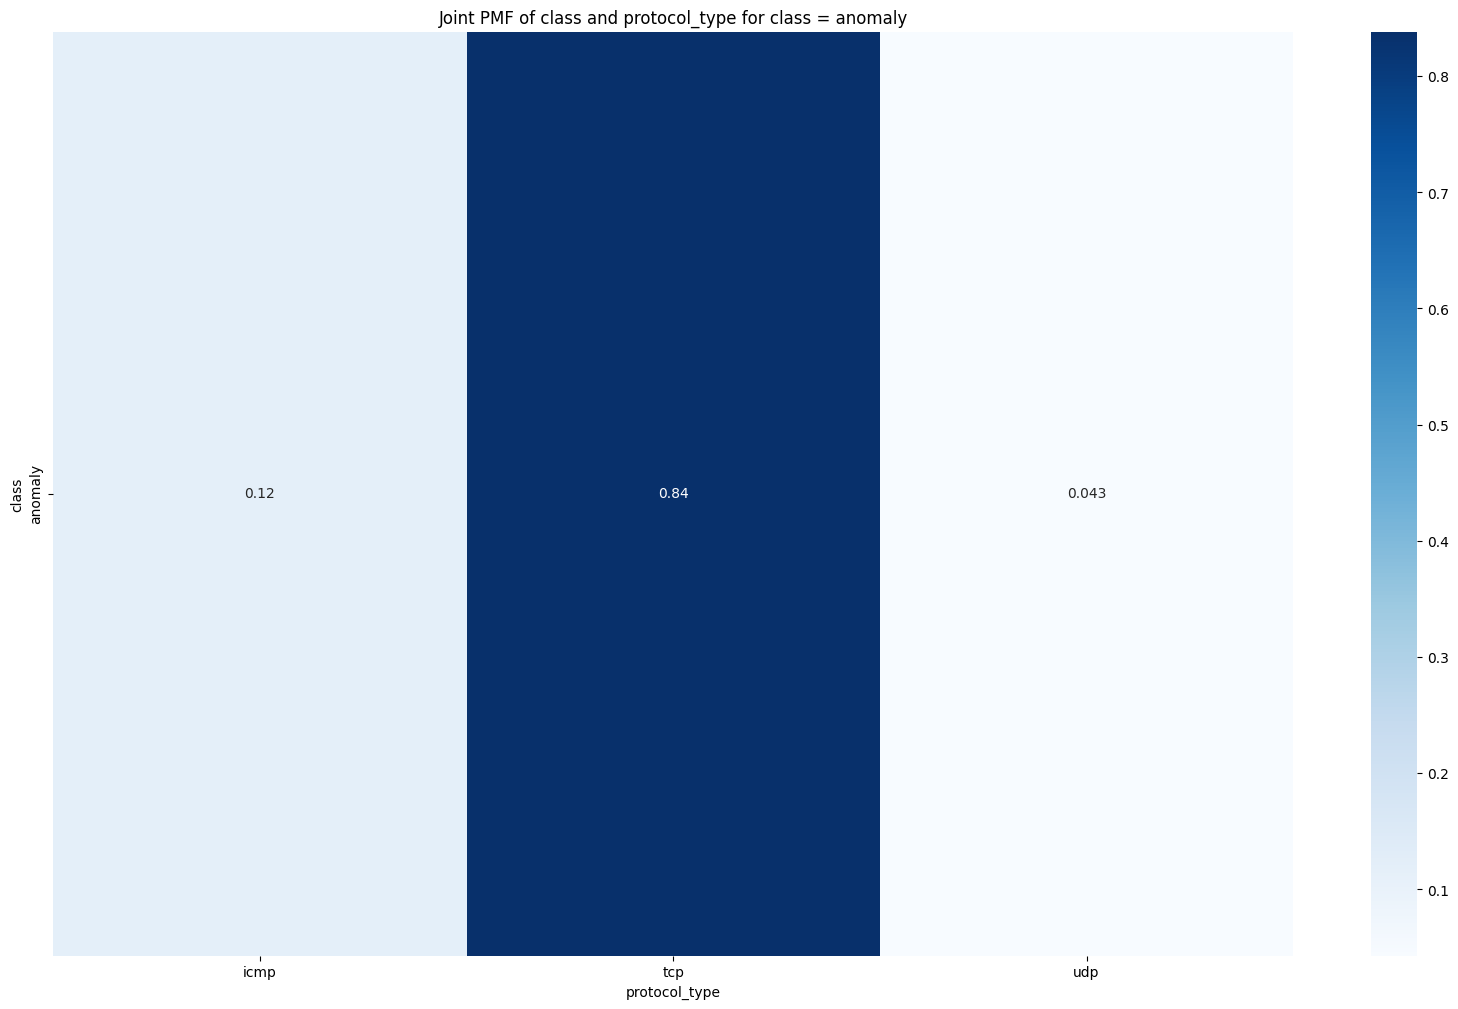

In [14]:
analyze_and_plot_distributions(df, 'class')
analyze_and_plot_joint_distribution(df, numeric_cols, categorical_cols)
plotscatter(numeric_cols)
analyze_and_plot_conditional_joint_distribution(df, 'class', numeric_cols, categorical_cols)